In [269]:
from tensorflow import keras
import matplotlib.pyplot as plt

In [247]:
import xarray
import numpy
import h5py
import scipy.interpolate
import datetime
import itertools
import pickle
import sys

mask = xarray.open_dataset('mask.h5')["mask"].values.astype(bool)
mask_lowres = xarray.open_dataset('mask_lowres.h5')["mask"].values.astype(bool)

model_data = xarray.open_dataset('../../gefs/ecmwf_anomalies.nc')['prec']
model_data = model_data.reindex(lat=model_data.lat[::-1]) + 6

obs_data = xarray.open_dataset('anomalies.nc')['p']

era = xarray.open_dataset('../era5_prec_anomalies.nc')['tp'].rename({'longitude': 'lon', 'latitude': 'lat'})
era = era.reindex(lat=era.lat[::-1]) + 6

clim_mean = xarray.open_dataset("clim_mean.nc")

clim_mean_era = xarray.open_dataset("clim_mean_era5.nc")*1000

pcs = xarray.open_dataset('pcs.h5')["pcs"].values.T
pcs2 = pcs.reshape(115, 275, 2)
pcs3 = pcs2[:92, :, :]

highres_lons, highres_lats = numpy.meshgrid(numpy.arange(66.5, 100.25, 0.25),
                                            numpy.arange(6.5, 38.75, 0.25))

lowres_lons, lowres_lats = numpy.meshgrid(model_data.lon, model_data.lat)

lonnan, latnan = numpy.where(~mask)
lonnan_lowres, latnan_lowres = numpy.where(~mask_lowres)

In [448]:
model_data

<xarray.DataArray 'prec' (ensemble: 25, initial_time: 120, forecast_time: 150, lat: 34, lon: 35)>
array([[[[[ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00, ...,
            1.11770630e+00,  1.69372559e+00,  3.81088257e+00],
          [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00, ...,
            2.21252441e-01,  6.40869141e-01,  8.22830200e+00],
          [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00, ...,
            1.56402588e-01,  1.46865845e+00,  2.55966187e+00],
          ...,
          [ 1.85775757e+00,  8.37326050e+00,  2.14004517e+00, ...,
            0.00000000e+00,  0.00000000e+00,  5.68389893e-01],
          [ 9.95635986e-01,  2.77328491e+00,  2.55966187e+00, ...,
            0.00000000e+00,  0.00000000e+00,  5.79833984e-01],
          [ 0.00000000e+00,  6.52694702e+00,  4.76074219e+00, ...,
            0.00000000e+00,  0.00000000e+00,  0.00000000e+00]],

         [[ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00, ...,
            2.82287598e-01,  3.49807739e+00,  1.02233887e+00],
          [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00, ...,
            6.29425049e-01,  1.61743164e+00,  2.36129761e+00],
          [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00, ...,
            1.60980225e+00,  1.37329102e+00,  6.29425049e-01],
...
            3.66210938e-01,  4.88281250e-01,  3.66210938e-01],
          [ 0.00000000e+00,  0.00000000e+00,  1.22070312e-01, ...,
            2.44140625e-01,  2.44140625e-01,  4.88281250e-01],
          [ 1.22070312e-01,  3.66210938e-01,  2.80761719e+00, ...,
            1.22070312e-01,  0.00000000e+00,  0.00000000e+00]],

         [[ 4.88281250e-01,  4.88281250e-01,  0.00000000e+00, ...,
            1.20849609e+01,  2.68554688e+00,  6.10351562e-01],
          [ 6.10351562e-01,  7.32421875e-01,  8.54492188e-01, ...,
            1.58691406e+00,  6.10351562e-01,  1.83105469e+00],
          [ 1.95312500e+00,  1.09863281e+00,  6.10351562e-01, ...,
            8.54492188e-01,  6.10351562e-01,  5.85937500e+00],
          ...,
          [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00, ...,
            0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
          [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00, ...,
            2.44140625e-01,  4.88281250e-01,  3.66210938e-01],
          [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00, ...,
            2.44140625e-01,  2.44140625e-01,  2.44140625e-01]]]]],
      dtype=float32)
Coordinates:
  * lat            (lat) float64 6.0 7.0 8.0 9.0 10.0 ... 36.0 37.0 38.0 39.0
  * forecast_time  (forecast_time) timedelta64[ns] 1 days 2 days ... 150 days
  * ensemble       (ensemble) int32 0 1 2 3 4 5 6 7 ... 17 18 19 20 21 22 23 24
  * lon            (lon) float32 66.0 67.0 68.0 69.0 ... 97.0 98.0 99.0 100.0
  * initial_time   (initial_time) datetime64[ns] 1993-05-01 ... 2016-09-01

In [65]:
era_anomalies = xarray.open_dataset('era5_anomalies.nc')['tp']

In [382]:
scaler_centered = pickle.load(open('scaler_centered', 'rb'))

scaler_past = pickle.load(open('scaler_past', 'rb'))

scaler_future = pickle.load(open('scaler_future', 'rb'))

scaler_may_june = pickle.load(open('scaler_may_june', 'rb'))

scaler_centered_era = pickle.load(open('scaler_centered_era', 'rb'))

scaler_future_era = pickle.load(open('scaler_future_era', 'rb'))

In [383]:
nn_model_centered = keras.models.load_model("nn_centered")
nn_model_past = keras.models.load_model("nn_past")
nn_model_future = keras.models.load_model("nn_future")
nn_model_may_june = keras.models.load_model("nn_may_june")
nn_model_era = keras.models.load_model("nn_centered_era")
nn_model_future_era = keras.models.load_model("nn_future_era")

In [362]:
def get_pcs_centered(data):                                                              
    return nn_model_centered(scaler_centered.transform(data)).numpy()

def get_pcs_centered_era(data):                                                              
    return nn_model_era(scaler_centered_era.transform(data/1000)).numpy()

def get_pcs_past(data):                                                              
    return nn_model_past(scaler_past.transform(data)).numpy()

def get_pcs_future(data):                                                              
    return nn_model_future(scaler_future.transform(data)).numpy()

def get_pcs_future_era(data):                                                              
    return nn_model_future_era(scaler_future_era.transform(data)).numpy()

def get_pcs_may_june(data):                                                              
    return nn_model_may_june(scaler_may_june.transform(data)).numpy()

In [298]:
def downscale(data):
    coords = numpy.vstack((lowres_lons.ravel(), lowres_lats.ravel())).T
    interp = scipy.interpolate.griddata(coords, data.ravel(), (highres_lons, highres_lats), method='cubic')
    interp[lonnan, latnan] = numpy.nan

    return interp

def upscale(data):
    coords = numpy.vstack((highres_lons.ravel(), highres_lats.ravel())).T
    interp = scipy.interpolate.griddata(coords, data.ravel(), (lowres_lons, lowres_lats), method='nearest')

    return interp

def forecast_pcs(initial_pcs, lead_time, k):
    if lead_time == 0:
        return initial_pcs
    pc_dist = numpy.sqrt(numpy.sum((pcs3 - initial_pcs)**2, axis=2))
    idx2 = numpy.unravel_index(numpy.argsort(pc_dist.ravel()), pc_dist.shape)
    idx2 = (idx2[0][:k], idx2[1][:k])
    day_dists = (idx2[1][1:] - idx2[1][:-1])
    year_dists = (idx2[0][1:] - idx2[0][:-1])
    too_close = numpy.where((year_dists == 0) & (day_dists <= 10))[0] + 1
    too_close_mask = numpy.ones(idx2[1].shape, dtype=bool)
    too_close_mask[too_close] = False
    same_year = (idx2[1] + lead_time) < 275
    dist_mask = pc_dist[idx2[0], idx2[1]] <= pc_radius
    dists = pc_dist[idx2[0][same_year & too_close_mask & dist_mask], idx2[1][same_year & too_close_mask & dist_mask]]
    pcs_fcst = (pcs3[idx2[0][same_year & too_close_mask & dist_mask], idx2[1][same_year & too_close_mask & dist_mask] + lead_time, :]/dists.reshape(-1, 1)).sum(axis=0)/sum(1/dists.reshape(-1, 1))
    return pcs_fcst

day = 1
day_i = day - 1
regress_days = 29
half_regress_days = 14
n_ens = 25
#average_days = 0
n_pcs = 2
k = 50
pc_radius = 1.0

In [417]:
def run_enoc(year, month, lead_time, m_p):
    def opt(m_p):
        best_ens = numpy.argsort(pc_dists)[:m_p]
        return model_data.sel(ensemble=best_ens, initial_time=initial_date).isel(forecast_time=range(day_i + lead_time - l_average_days - 1, day_i + lead_time + r_average_days)).mean(["ensemble", "forecast_time"])

    def rand(m_p):
        best_ens = numpy.arange(n_ens)
        numpy.random.shuffle(best_ens)
        best_ens = best_ens[:m_p]
        return model_data.sel(ensemble=best_ens, initial_time=initial_date).isel(forecast_time=range(day_i + lead_time - l_average_days - 1, day_i + lead_time + r_average_days)).mean(["ensemble", "forecast_time"])

    initial_date = datetime.datetime(year=year, month=month, day=day)

    initial_data = numpy.hstack([obs_data.sel(time=initial_date + datetime.timedelta(days=i)).values[mask] for i in range(-60 + 1, 1)])
    initial_pc = numpy.array(get_pcs_past(initial_data.reshape(1, -1)))

    date_days = (datetime.datetime(year=year, month=month, day=day) - datetime.datetime(year=year, month=3, day=1)).days
    initial_pc_true = pcs2[year - 1901, date_days + day_i, :]

    pcs_fcst = forecast_pcs(initial_pc, lead_time, k=k)

    pcs_model = numpy.zeros((n_ens, n_pcs))

    for ens in range(n_ens):
        if lead_time < half_regress_days:
            #data_ens = [(downscale(model_data.sel(initial_time=initial_date, ensemble=ens).isel(forecast_time=i).values) - clim_mean['p'].isel(dayofyear=61+date_days+i).values)[mask] for i in range(day_i + lead_time, day_i + lead_time + regress_days)]
            #pcs_model[ens, :] = numpy.array(get_pcs_future(numpy.hstack(data_ens).reshape(1, -1)))
            data_ens = [(model_data.sel(initial_time=initial_date, ensemble=ens).isel(forecast_time=i-1).values - clim_mean_era['tp'].isel(dayofyear=-61+date_days+i).values).ravel() for i in range(day_i + lead_time, day_i + lead_time + regress_days)]
            pcs_model[ens, :] = numpy.array(get_pcs_future_era(numpy.hstack(data_ens).reshape(1, -1)))
        else:
            #data_ens = [(downscale(model_data.sel(initial_time=initial_date, ensemble=ens).isel(forecast_time=i).values) - clim_mean['p'].isel(dayofyear=61+date_days+i).values)[mask] for i in range(day_i + lead_time - half_regress_days, day_i + lead_time + half_regress_days + 1)]
            #pcs_model[ens, :] = numpy.array(get_pcs_centered(numpy.hstack(data_ens).reshape(1, -1)))
            data_ens = [(model_data.sel(initial_time=initial_date, ensemble=ens).isel(forecast_time=i-1).values - clim_mean_era['tp'].isel(dayofyear=-61+date_days+i).values).ravel() for i in range(day_i + lead_time - half_regress_days, day_i + lead_time + half_regress_days + 1)]
            pcs_model[ens, :] = numpy.array(get_pcs_centered_era(numpy.hstack(data_ens).reshape(1, -1)))

    mean_pc = pcs_model.mean(axis=0)
    true_pc = pcs2[year - 1901, date_days + day_i + lead_time, :]
    pc_dists = numpy.mean((pcs_model - pcs_fcst)**2, axis=1)

    if not any(numpy.isnan(pc_dists)):
        best_ens = numpy.argsort(pc_dists)[:m_p]
    else:
        best_ens = range(n_ens)

    #cli_mean_averaged = clim_mean['p'].isel(dayofyear=range(61 + date_days + lead_time - l_average_days, 61 + date_days + lead_time + r_average_days + 1)).mean('dayofyear')
    #cli_mean_averaged_era = clim_mean_era['tp'].isel(dayofyear=range(date_days + lead_time - l_average_days, date_days + lead_time + r_average_days + 1)).mean('dayofyear')
    cli_mean_averaged_era = clim_30_year.isel(dayofyear=range(date_days + lead_time - l_average_days, date_days + lead_time + r_average_days + 1)).mean('dayofyear')
    cli_mean_model = model_clim.isel(dayofyear=month-5, forecast_time=range(lead_time - l_average_days - 1, lead_time + r_average_days)).mean('forecast_time')
    #cli_mean = clim_mean['p'].isel(dayofyear=61 + date_days + lead_time)

    #weights = 1/lin_model.predict(pc_dists.reshape(-1, 1))
    #weights = 1/(10 + pc_dists)
    enoc_pred = model_data.sel(ensemble=best_ens, initial_time=initial_date).isel(forecast_time=range(day_i + lead_time - l_average_days - 1, day_i + lead_time + r_average_days)).mean(["ensemble", "forecast_time"])
    #enoc_pred = (model_data.sel(ensemble=range(n_ens), initial_time=initial_date).isel(forecast_time=range(day_i + lead_time - average_days, day_i + lead_time + average_days + 1)).mean("forecast_time")*weights.reshape(n_ens, 1, 1)).sum('ensemble')/sum(weights)

    mean_pred = model_data.sel(ensemble=range(n_ens), initial_time=initial_date).isel(forecast_time=range(day_i + lead_time - l_average_days - 1, day_i + lead_time + r_average_days)).mean(["ensemble", "forecast_time"])

    #ens_members = [((model_data.sel(initial_time=initial_date, ensemble=ens).isel(forecast_time=lead_time)) - upscale(clim_mean['p'].isel(dayofyear=61+date_days+lead_time).values)).values[mask_lowres] for ens in range(n_ens)]
    #ens_members = [(downscale(model_data.sel(initial_time=initial_date, ensemble=ens).isel(forecast_time=lead_time)) + 6 - clim_mean['p'].isel(dayofyear=61+date_days+lead_time).values)[mask] for ens in range(n_ens)]
    #ens_members = [((model_data.sel(initial_time=initial_date, ensemble=ens).isel(forecast_time=lead_time-1)) - (clim_mean_era['tp'].isel(dayofyear=date_days+lead_time).values)).values[mask_lowres] for ens in range(n_ens)]

    #E = numpy.array(ens_members)
    #x_mean = numpy.mean(E, axis=0)
    #etkf_pred = etkf(E.T, x_mean.reshape(-1, 1), pcs_model.T, mean_pc.reshape(-1, 1), pcs_fcst.reshape(-1, 1), R)

    #obs_state = numpy.mean([obs_data.sel(time=initial_date + datetime.timedelta(days=i)) for i in range(lead_time - l_average_days, lead_time + r_average_days + 1)], axis=0)
    #obs_state_era = (numpy.mean([era.sel(time=initial_date + datetime.timedelta(days=i)) for i in range(lead_time - l_average_days, lead_time + r_average_days + 1)], axis=0)) - (cli_mean_averaged_era.values)
    obs_state_era = numpy.mean([era_anomalies.sel(time=initial_date + datetime.timedelta(days=i)) for i in range(lead_time - l_average_days, lead_time + r_average_days + 1)], axis=0)
    #obs_state_era_naveraged = era.sel(time=initial_date + datetime.timedelta(days=lead_time)) - clim_mean_era['tp'].isel(dayofyear=date_days+lead_time).values

    #opt_weights, _ = scipy.optimize.nnls(E.T, obs_state_era_naveraged.values[mask_lowres])#numpy.linalg.lstsq(E.T, obs_state_era[mask_lowres])
    #cli_mean = numpy.mean([clim_mean["prec"].isel(initial_time=month - 5, forecast_time=range(day_i + lead_time - average_days, day_i + lead_time + average_days + 1))], axis=0)

    opt_mp = [numpy.sqrt(numpy.nanmean((obs_state_era - (opt(i) - (cli_mean_model.values)))**2)) for i in range(1, n_ens+1)]
    rand_mp = [numpy.sqrt(numpy.nanmean((obs_state_era - (rand(i) - (cli_mean_model.values)))**2)) for i in range(1, n_ens+1)]
    #ens_err = [numpy.mean((m - obs_state[mask])**2) for m in ens_members]

    enoc_ens = model_data.sel(ensemble=best_ens, initial_time=initial_date).isel(forecast_time=day_i + lead_time - 1)
    mean_ens = model_data.sel(ensemble=range(n_ens), initial_time=initial_date).isel(forecast_time=day_i + lead_time - 1)

    #err_corr = numpy.sqrt(numpy.nanmean(((numpy.flipud(enoc_pred) - upscale(cli_mean_averaged.values))[mask_lowres] - upscale(obs_state)[mask_lowres])**2))
    #err_corr = numpy.sqrt(numpy.nanmean((etkf_pred.mean(axis=1) - obs_state[mask])**2))
    #err_uncorr = numpy.sqrt(numpy.nanmean(((numpy.flipud(mean_pred) - upscale(cli_mean_averaged.values))[mask_lowres] - upscale(obs_state)[mask_lowres])**2))

    err_corr = numpy.sqrt(numpy.nanmean((((enoc_pred) - (cli_mean_model.values)).values - (obs_state_era))**2))
    #err_corr = numpy.sqrt(numpy.nanmean((etkf_pred.mean(axis=1) - (obs_state_era)[mask_lowres])**2))
    #err_uncorr = numpy.sqrt(numpy.nanmean(((numpy.flipud(mean_pred) - upscale(cli_mean_averaged.values))[mask_lowres] - upscale(obs_state)[mask_lowres])**2))    
    err_uncorr = numpy.sqrt(numpy.nanmean((((mean_pred) - (cli_mean_model.values)).values - (obs_state_era))**2))

    print("Year: ", year)
    print(err_corr, err_uncorr, err_corr/err_uncorr)

    opt_mps.append(opt_mp)
    rand_mps.append(rand_mp)
    fcst_pcs.append(pcs_fcst)
    true_pcs.append(true_pc)
    pred_corr.append(enoc_pred)
    pred_uncorr.append(mean_pred)
    ens_corr.append(enoc_ens)
    ens_uncorr.append(mean_ens)
    errs_corr.append(err_corr)
    errs_uncorr.append(err_uncorr)
    obs_states.append(obs_state_era)
    clim_means_averaged.append(cli_mean_averaged_era)
    #clim_means.append(cli_mean)
    initial_pcs.append(initial_pc)
    initial_pcs_true.append(initial_pc_true)
    #ens_errs.append(ens_err)
    ens_dists.append(pc_dists)
    model_clims.append(cli_mean_model)
    #all_opt_weights.append(opt_weights)

In [416]:
clim_30_year

<xarray.DataArray 'tp' (dayofyear: 275, lat: 34, lon: 35)>
array([[[ 1.6494067 ,  2.054006  ,  2.1210072 , ...,  2.6933272 ,
          1.4839791 ,  1.330723  ],
        [ 1.0459719 ,  1.1851248 ,  1.1887678 , ...,  2.1943264 ,
          0.8821573 ,  1.4774485 ],
        [ 0.4392925 ,  0.48410755,  0.6036532 , ...,  1.6487913 ,
          1.7234931 ,  1.6610163 ],
        ...,
        [ 1.7693701 ,  1.3325081 ,  2.1598573 , ...,  0.09112922,
          0.18547685,  0.0847301 ],
        [ 2.3053086 ,  3.6072686 ,  3.4824135 , ...,  0.34743723,
          0.36317986,  0.6157062 ],
        [ 2.3891678 ,  4.047577  ,  5.7670035 , ...,  0.41104192,
          0.61774004,  0.7555916 ]],

       [[ 1.3860707 ,  1.2210383 ,  1.3152078 , ...,  1.7500379 ,
          1.3285304 ,  0.80924106],
        [ 0.81591845,  0.8346092 ,  0.5726841 , ...,  1.1235826 ,
          0.42238015,  1.0868547 ],
        [ 0.4175835 ,  0.32330075,  0.44835076, ...,  1.0156382 ,
          1.0719261 ,  1.1489565 ],
...
        [ 1.5443423 ,  1.5902553 ,  0.9254609 , ...,  0.03223668,
          0.02499053,  0.12538967],
        [ 1.265279  ,  2.054832  ,  1.3546813 , ...,  0.03161072,
          0.02512522,  0.02482697],
        [ 1.7789543 ,  3.4376884 ,  6.6254873 , ...,  0.11447597,
          0.12103817,  0.04366774]],

       [[ 9.630884  ,  8.748748  , 10.630867  , ..., 16.885996  ,
         12.401282  ,  6.012192  ],
        [ 8.96942   ,  8.5796795 ,  8.896242  , ..., 10.130778  ,
          5.5081525 ,  8.221119  ],
        [ 6.98205   ,  6.740056  ,  7.3496203 , ...,  4.2645226 ,
          4.057689  ,  5.977405  ],
        ...,
        [ 1.6170303 ,  1.7277861 ,  1.5722165 , ...,  0.05931175,
          0.07080881,  0.29166374],
        [ 1.5964061 ,  3.3443844 ,  1.7821554 , ...,  0.02231205,
          0.03708398,  0.04544854],
        [ 1.5778401 ,  3.5726054 ,  5.3522944 , ...,  0.13817126,
          0.25669265,  0.20430169]]], dtype=float32)
Coordinates:
  * lat        (lat) float64 6.0 7.0 8.0 9.0 10.0 ... 35.0 36.0 37.0 38.0 39.0
  * lon        (lon) float32 66.0 67.0 68.0 69.0 70.0 ... 97.0 98.0 99.0 100.0
  * dayofyear  (dayofyear) object '03-01' '03-02' '03-03' ... '11-29' '11-30'

In [414]:
clim_mean_era

<xarray.Dataset>
Dimensions:    (dayofyear: 153, lat: 34, lon: 35)
Coordinates:
  * lat        (lat) float32 6.0 7.0 8.0 9.0 10.0 ... 35.0 36.0 37.0 38.0 39.0
  * lon        (lon) float32 66.0 67.0 68.0 69.0 70.0 ... 97.0 98.0 99.0 100.0
  * dayofyear  (dayofyear) object '05-01' '05-02' '05-03' ... '09-29' '09-30'
Data variables:
    tp         (dayofyear, lat, lon) float32 4.627813 5.089957 ... 1.397589

In [411]:
clim_30_year

<xarray.DataArray 'tp' (dayofyear: 275, lat: 34, lon: 35)>
array([[[ 1.6494067 ,  2.054006  ,  2.1210072 , ...,  2.6933272 ,
          1.4839791 ,  1.330723  ],
        [ 1.0459719 ,  1.1851248 ,  1.1887678 , ...,  2.1943264 ,
          0.8821573 ,  1.4774485 ],
        [ 0.4392925 ,  0.48410755,  0.6036532 , ...,  1.6487913 ,
          1.7234931 ,  1.6610163 ],
        ...,
        [ 1.7693701 ,  1.3325081 ,  2.1598573 , ...,  0.09112922,
          0.18547685,  0.0847301 ],
        [ 2.3053086 ,  3.6072686 ,  3.4824135 , ...,  0.34743723,
          0.36317986,  0.6157062 ],
        [ 2.3891678 ,  4.047577  ,  5.7670035 , ...,  0.41104192,
          0.61774004,  0.7555916 ]],

       [[ 1.3860707 ,  1.2210383 ,  1.3152078 , ...,  1.7500379 ,
          1.3285304 ,  0.80924106],
        [ 0.81591845,  0.8346092 ,  0.5726841 , ...,  1.1235826 ,
          0.42238015,  1.0868547 ],
        [ 0.4175835 ,  0.32330075,  0.44835076, ...,  1.0156382 ,
          1.0719261 ,  1.1489565 ],
...
        [ 1.5443423 ,  1.5902553 ,  0.9254609 , ...,  0.03223668,
          0.02499053,  0.12538967],
        [ 1.265279  ,  2.054832  ,  1.3546813 , ...,  0.03161072,
          0.02512522,  0.02482697],
        [ 1.7789543 ,  3.4376884 ,  6.6254873 , ...,  0.11447597,
          0.12103817,  0.04366774]],

       [[ 9.630884  ,  8.748748  , 10.630867  , ..., 16.885996  ,
         12.401282  ,  6.012192  ],
        [ 8.96942   ,  8.5796795 ,  8.896242  , ..., 10.130778  ,
          5.5081525 ,  8.221119  ],
        [ 6.98205   ,  6.740056  ,  7.3496203 , ...,  4.2645226 ,
          4.057689  ,  5.977405  ],
        ...,
        [ 1.6170303 ,  1.7277861 ,  1.5722165 , ...,  0.05931175,
          0.07080881,  0.29166374],
        [ 1.5964061 ,  3.3443844 ,  1.7821554 , ...,  0.02231205,
          0.03708398,  0.04544854],
        [ 1.5778401 ,  3.5726054 ,  5.3522944 , ...,  0.13817126,
          0.25669265,  0.20430169]]], dtype=float32)
Coordinates:
  * lat        (lat) float64 6.0 7.0 8.0 9.0 10.0 ... 35.0 36.0 37.0 38.0 39.0
  * lon        (lon) float32 66.0 67.0 68.0 69.0 70.0 ... 97.0 98.0 99.0 100.0
  * dayofyear  (dayofyear) object '03-01' '03-02' '03-03' ... '11-29' '11-30'

def run_enoc_new(year, month, lead_time, m_p):
    def opt(m_p):
        best_ens = numpy.argsort(pc_dists)[:m_p]
        return forecasts.sel(ensemble=best_ens, initial_time=initial_date).isel(forecast_time=range(day_i + lead_time - l_average_days - 1, day_i + lead_time + r_average_days)).mean(["ensemble", "forecast_time"])

    def rand(m_p):
        best_ens = numpy.arange(n_ens)
        numpy.random.shuffle(best_ens)
        best_ens = best_ens[:m_p]
        return forecasts.sel(ensemble=best_ens, initial_time=initial_date).isel(forecast_time=range(day_i + lead_time - l_average_days - 1, day_i + lead_time + r_average_days)).mean(["ensemble", "forecast_time"])

    initial_date = datetime.datetime(year=year, month=month, day=day)

    initial_data = numpy.hstack([obs_data.sel(time=initial_date + datetime.timedelta(days=i)).values[mask] for i in range(-30 + 1, 1)])
    initial_pc = numpy.array(get_pcs_past(initial_data.reshape(1, -1)))

    date_days = (datetime.datetime(year=year, month=month, day=day) - datetime.datetime(year=year, month=5, day=1)).days
    initial_pc_true = pcs2[year - 1901, date_days + day_i, :]

    pcs_fcst = forecast_pcs(initial_pc, lead_time, k=k)

    pcs_model = numpy.zeros((n_ens, n_pcs))

    for ens in range(n_ens):
        if lead_time < half_regress_days:
            #data_ens = [(downscale(model_data.sel(initial_time=initial_date, ensemble=ens).isel(forecast_time=i).values) - clim_mean['p'].isel(dayofyear=61+date_days+i).values)[mask] for i in range(day_i + lead_time, day_i + lead_time + regress_days)]
            #pcs_model[ens, :] = numpy.array(get_pcs_future(numpy.hstack(data_ens).reshape(1, -1)))
            data_ens = [(forecasts.sel(initial_time=initial_date, ensemble=ens).isel(forecast_time=i-1).values - clim_mean_era['tp'].isel(dayofyear=date_days+i).values).ravel() for i in range(day_i + lead_time, day_i + lead_time + regress_days)]
            pcs_model[ens, :] = numpy.array(get_pcs_future_era(numpy.hstack(data_ens).reshape(1, -1)))
        else:
            #data_ens = [(downscale(model_data.sel(initial_time=initial_date, ensemble=ens).isel(forecast_time=i).values) - clim_mean['p'].isel(dayofyear=61+date_days+i).values)[mask] for i in range(day_i + lead_time - half_regress_days, day_i + lead_time + half_regress_days + 1)]
            #pcs_model[ens, :] = numpy.array(get_pcs_centered(numpy.hstack(data_ens).reshape(1, -1)))
            data_ens = [(forecasts.sel(initial_time=initial_date, ensemble=ens).isel(forecast_time=i-1).values - clim_mean_era['tp'].isel(dayofyear=date_days+i).values).ravel() for i in range(day_i + lead_time - half_regress_days, day_i + lead_time + half_regress_days + 1)]
            pcs_model[ens, :] = numpy.array(get_pcs_centered_era(numpy.hstack(data_ens).reshape(1, -1)))

    mean_pc = pcs_model.mean(axis=0)
    true_pc = pcs2[year - 1901, date_days + day_i + lead_time, :]
    pc_dists = numpy.mean((pcs_model - pcs_fcst)**2, axis=1)

    if not any(numpy.isnan(pc_dists)):
        best_ens = numpy.argsort(pc_dists)[:m_p]
    else:
        best_ens = range(n_ens)

    cli_mean_averaged = clim_mean['p'].isel(dayofyear=range(61 + date_days + lead_time - l_average_days, 61 + date_days + lead_time + r_average_days + 1)).mean('dayofyear')
    cli_mean_averaged_era = clim_mean_era['tp'].isel(dayofyear=range(date_days + lead_time - l_average_days, date_days + lead_time + r_average_days + 1)).mean('dayofyear')
    cli_mean_model = model_clim.isel(dayofyear=month-5, forecast_time=range(lead_time - l_average_days - 1, lead_time + r_average_days)).mean('forecast_time')
    cli_mean = clim_mean['p'].isel(dayofyear=61 + date_days + lead_time)

    #weights = 1/lin_model.predict(pc_dists.reshape(-1, 1))
    #weights = 1/(10 + pc_dists)
    enoc_pred = forecasts.sel(ensemble=best_ens, initial_time=initial_date).isel(forecast_time=range(day_i + lead_time - l_average_days - 1, day_i + lead_time + r_average_days)).mean(["ensemble", "forecast_time"])
    #enoc_pred = (model_data.sel(ensemble=range(n_ens), initial_time=initial_date).isel(forecast_time=range(day_i + lead_time - average_days, day_i + lead_time + average_days + 1)).mean("forecast_time")*weights.reshape(n_ens, 1, 1)).sum('ensemble')/sum(weights)

    mean_pred = forecasts.sel(ensemble=range(n_ens), initial_time=initial_date).isel(forecast_time=range(day_i + lead_time - l_average_days - 1, day_i + lead_time + r_average_days)).mean(["ensemble", "forecast_time"])

    #ens_members = [((model_data.sel(initial_time=initial_date, ensemble=ens).isel(forecast_time=lead_time)) - upscale(clim_mean['p'].isel(dayofyear=61+date_days+lead_time).values)).values[mask_lowres] for ens in range(n_ens)]
    #ens_members = [(downscale(model_data.sel(initial_time=initial_date, ensemble=ens).isel(forecast_time=lead_time)) + 6 - clim_mean['p'].isel(dayofyear=61+date_days+lead_time).values)[mask] for ens in range(n_ens)]
    #ens_members = [((forecasts.sel(initial_time=initial_date, ensemble=ens).isel(forecast_time=lead_time-1)) - (clim_mean_era['tp'].isel(dayofyear=date_days+lead_time).values)).values[mask_lowres] for ens in range(n_ens)]

    #E = numpy.array(ens_members)
    #x_mean = numpy.mean(E, axis=0)
    #etkf_pred = etkf(E.T, x_mean.reshape(-1, 1), pcs_model.T, mean_pc.reshape(-1, 1), pcs_fcst.reshape(-1, 1), R)

    obs_state = numpy.mean([obs_data.sel(time=initial_date + datetime.timedelta(days=i)) for i in range(lead_time - l_average_days, lead_time + r_average_days + 1)], axis=0)
    obs_state_era = (numpy.mean([era.sel(time=initial_date + datetime.timedelta(days=i)) for i in range(lead_time - l_average_days, lead_time + r_average_days + 1)], axis=0)) - (cli_mean_averaged_era.values)
    obs_state_era_naveraged = era.sel(time=initial_date + datetime.timedelta(days=lead_time)) - clim_mean_era['tp'].isel(dayofyear=date_days+lead_time).values

    #opt_weights, _ = scipy.optimize.nnls(E.T, obs_state_era_naveraged.values[mask_lowres])#numpy.linalg.lstsq(E.T, obs_state_era[mask_lowres])
    #cli_mean = numpy.mean([clim_mean["prec"].isel(initial_time=month - 5, forecast_time=range(day_i + lead_time - average_days, day_i + lead_time + average_days + 1))], axis=0)

    opt_mp = [numpy.sqrt(numpy.nanmean((obs_state_era - (opt(i) - (cli_mean_model.values)))**2)) for i in range(1, n_ens+1)]
    rand_mp = [numpy.sqrt(numpy.nanmean((obs_state_era - (rand(i) - (cli_mean_model.values)))**2)) for i in range(1, n_ens+1)]
    #ens_err = [numpy.mean((m - obs_state[mask])**2) for m in ens_members]

    enoc_ens = forecasts.sel(ensemble=best_ens, initial_time=initial_date).isel(forecast_time=day_i + lead_time - 1)
    mean_ens = forecasts.sel(ensemble=range(n_ens), initial_time=initial_date).isel(forecast_time=day_i + lead_time - 1)

    #err_corr = numpy.sqrt(numpy.nanmean(((numpy.flipud(enoc_pred) - upscale(cli_mean_averaged.values))[mask_lowres] - upscale(obs_state)[mask_lowres])**2))
    #err_corr = numpy.sqrt(numpy.nanmean((etkf_pred.mean(axis=1) - obs_state[mask])**2))
    #err_uncorr = numpy.sqrt(numpy.nanmean(((numpy.flipud(mean_pred) - upscale(cli_mean_averaged.values))[mask_lowres] - upscale(obs_state)[mask_lowres])**2))

    err_corr = numpy.sqrt(numpy.nanmean((((enoc_pred) - (cli_mean_model.values)).values - (obs_state_era))**2))
    #err_corr = numpy.sqrt(numpy.nanmean((etkf_pred.mean(axis=1) - (obs_state_era)[mask_lowres])**2))
    #err_uncorr = numpy.sqrt(numpy.nanmean(((numpy.flipud(mean_pred) - upscale(cli_mean_averaged.values))[mask_lowres] - upscale(obs_state)[mask_lowres])**2))    
    err_uncorr = numpy.sqrt(numpy.nanmean((((mean_pred) - (cli_mean_model.values)).values - (obs_state_era))**2))

    print("Year: ", year)
    print(err_corr, err_uncorr, err_corr/err_uncorr)

    opt_mps.append(opt_mp)
    rand_mps.append(rand_mp)
    fcst_pcs.append(pcs_fcst)
    true_pcs.append(true_pc)
    pred_corr.append(enoc_pred)
    pred_uncorr.append(mean_pred)
    ens_corr.append(enoc_ens)
    ens_uncorr.append(mean_ens)
    errs_corr.append(err_corr)
    errs_uncorr.append(err_uncorr)
    obs_states.append(obs_state_era)
    clim_means_averaged.append(cli_mean_averaged_era)
    clim_means.append(cli_mean)
    initial_pcs.append(initial_pc)
    initial_pcs_true.append(initial_pc_true)
    #ens_errs.append(ens_err)
    ens_dists.append(pc_dists)
    model_clims.append(cli_mean_model)
    #all_opt_weights.append(opt_weights)

In [982]:
model_clim.isel(dayofyear=month-5, forecast_time=range(lead_time - l_average_days - 1, lead_time + r_average_days)).mean('forecast_time')

<xarray.DataArray 'prec' (lat: 34, lon: 35)>
array([[4.60489845e+00, 5.15553427e+00, 5.45398855e+00, ...,
        7.25550938e+00, 9.94278336e+00, 1.26160192e+01],
       [4.06721020e+00, 4.74646997e+00, 5.42291832e+00, ...,
        8.12350559e+00, 1.25161095e+01, 1.10617523e+01],
       [4.12102079e+00, 4.58839560e+00, 5.01415730e+00, ...,
        1.30193777e+01, 1.25802965e+01, 7.67240334e+00],
       ...,
       [1.20629207e-03, 4.08045435e-03, 8.51101242e-03, ...,
        9.95946646e-01, 1.65901077e+00, 3.08029556e+00],
       [4.15420486e-03, 1.59835834e-02, 1.36108380e-02, ...,
        2.14886498e+00, 2.54347324e+00, 3.83665872e+00],
       [9.61685181e-03, 7.68330917e-02, 4.94658113e-01, ...,
        2.13513637e+00, 2.88824201e+00, 1.29597604e+00]], dtype=float32)
Coordinates:
  * lat        (lat) float64 6.0 7.0 8.0 9.0 10.0 ... 35.0 36.0 37.0 38.0 39.0
  * lon        (lon) float32 66.0 67.0 68.0 69.0 70.0 ... 97.0 98.0 99.0 100.0
    dayofyear  <U5 '09-01'

In [548]:
initial_date

datetime.datetime(1998, 7, 1, 0, 0)

In [357]:
def etkf(E, x_mean, pcs_model, pc_mean, pc_fcst, R):
    R_inv = numpy.linalg.inv(R)
    X = (E - x_mean)/numpy.sqrt(n_ens - 1)
    Y = (pcs_model - pc_mean)/numpy.sqrt(n_ens - 1)
    Omega = numpy.linalg.inv(numpy.eye(n_ens) + Y.T@R_inv@Y)
    w = Omega@Y.T@R_inv@(pc_fcst - pc_mean)
    E_a = x_mean + X@(w + numpy.sqrt(n_ens - 1)*scipy.linalg.sqrtm(Omega).real)
    return E_a

In [385]:
def run_pc_fcst(year, month, lead_time, m_p):
    initial_date = datetime.datetime(year=year, month=month, day=day)

    if (month == 5) or (month == 6):
        initial_data = numpy.hstack([obs_data.sel(time=initial_date + datetime.timedelta(days=i)).values[mask] for i in range(-29 + 1, 1)])
        initial_pc = numpy.array(get_pcs_may_june(initial_data.reshape(1, -1)))[0]
    else:
        initial_data = numpy.hstack([obs_data.sel(time=initial_date + datetime.timedelta(days=i)).values[mask] for i in range(-60 + 1, 1)])
        initial_pc = numpy.array(get_pcs_past(initial_data.reshape(1, -1)))[0]

    date_days = (datetime.datetime(year=year, month=month, day=day) - datetime.datetime(year=year, month=3, day=1)).days
    initial_pc_true = pcs2[year - 1901, date_days + day_i, :]

    pcs_fcst = forecast_pcs(initial_pc, lead_time, k=k)

    true_pc = pcs2[year - 1901, date_days + day_i + lead_time, :]

    fcst_pcs.append(pcs_fcst)
    true_pcs.append(true_pc)
    initial_pcs.append(initial_pc)
    initial_pcs_true.append(initial_pc_true)

In [1930]:
def run_sel(year, month, lead_time):
    initial_date = datetime.datetime(year=year, month=month, day=day)

    date_days = (datetime.datetime(year=year, month=month, day=day) - datetime.datetime(year=year, month=5, day=day)).days

    cli_mean_averaged = clim_mean['p'].isel(dayofyear=range(61 + date_days + lead_time - average_days, 61 + date_days + lead_time + average_days + 1)).mean('dayofyear')
    cli_mean = clim_mean['p'].isel(dayofyear=61 + date_days + lead_time)

    obs_state = numpy.mean([obs_data.sel(time=initial_date + datetime.timedelta(days=i)) for i in range(lead_time - average_days, lead_time + average_days + 1)], axis=0)
    obs_state_era = numpy.flipud(numpy.mean([era.sel(time=initial_date + datetime.timedelta(days=i)) for i in range(lead_time - average_days, lead_time + average_days + 1)], axis=0)) + 6 - upscale(cli_mean_averaged.values)

    #err_uncorr = numpy.sqrt(numpy.nanmean(((numpy.flipud(mean_pred) - upscale(cli_mean_averaged.values))[mask_lowres] - upscale(obs_state)[mask_lowres])**2))    
    err_uncorr = numpy.sqrt(numpy.nanmean(((numpy.flipud(mean_pred) - upscale(cli_mean_averaged.values))[mask_lowres] - (obs_state_era)[mask_lowres])**2))
    
    print("Year: ", year)

    errs_uncorr.append(err_uncorr)
    obs_states.append(obs_state_era)
    clim_means_averaged.append(cli_mean_averaged)
    clim_means.append(cli_mean)

In [463]:
m_p = 20

opt_mps = []
rand_mps = []
true_pcs = []
fcst_pcs = []
pred_corr = []
pred_uncorr = []
ens_corr = []
ens_uncorr = []
obs_states = []
clim_means_averaged = []
clim_means = []
initial_pcs_true = []
initial_pcs = []
errs_corr = []
errs_uncorr = []
ens_errs = []
ens_dists = []
all_errs_corr = []
all_errs_uncorr = []
all_opt_weights = []
model_clims = []

l_average_days = 7
r_average_days = 7

for month in range(7, 8):
    for lead_time in range(20, 21):
        opt_mps = []
        for year in range(1993, 2008):
            run_enoc(year, month, lead_time, m_p)
        
        #global lin_model
        #nanmask = numpy.isnan(numpy.ravel(ens_dists))
        #lin_model = LinearRegression().fit(numpy.ravel(ens_dists)[~nanmask].reshape(-1, 1), numpy.ravel(ens_errs)[~nanmask])
        
        #if lin_model.coef_ > 0:
        #    lin_model.coef_ *= 10
        #else:
        #    lin_model.coef_ *= -10
        m_p = numpy.argmin(numpy.mean(opt_mps, axis=0)) + 1
        print(m_p)
        global errs_corr
        global errs_uncorr
        errs_corr = []
        errs_uncorr = []
        for year in range(2008, 2016):
            run_enoc(year, month, lead_time, m_p)

        all_errs_corr.append(errs_corr)
        all_errs_uncorr.append(errs_uncorr)

Year:  1993
4.0038047 3.9027474 1.0258939
Year:  1994
3.1834855 3.0791278 1.0338919
Year:  1995
4.1143827 3.9678729 1.036924
Year:  1996
4.376966 4.4364853 0.9865841
Year:  1997
4.120077 4.017554 1.0255189
Year:  1998
4.400828 4.6198006 0.95260125
Year:  1999
4.3284674 4.5191402 0.9578077


KeyboardInterrupt: 

In [461]:
numpy.mean(errs_corr), numpy.mean(errs_uncorr)

(4.2550707, 4.322654)

In [432]:
numpy.argmin(numpy.mean(opt_mps[15:], axis=0)) + 1

17

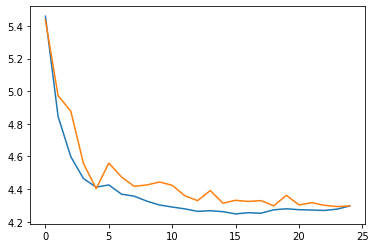

In [433]:
plt.plot(numpy.mean(opt_mps, axis=0))
plt.plot(numpy.mean(rand_mps, axis=0))

ValueError: x and y must have same first dimension, but have shapes (20,) and (1,)

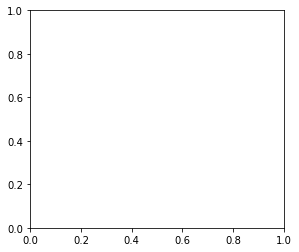

In [15]:
plt.figure(figsize=(10, 4))

plt.subplot(1, 2, 1)
plt.plot(range(10, 30), [7*numpy.mean(e) for e in all_errs_uncorr[:20]])
plt.plot(range(10, 30), [7*numpy.mean(e) for e in all_errs_corr[:20]])
plt.plot(range(10, 30), numpy.array(stds[:20])*7)
plt.legend(["Corrected", "Uncorrected"])
plt.xlabel("Lead time (days)")
plt.ylabel("RMSE (mm/day)")
plt.title('July')

plt.subplot(1, 2, 2)
plt.plot(range(10, 30), [7*numpy.mean(e) for e in all_errs_uncorr[20:40]])
plt.plot(range(10, 30), [7*numpy.mean(e) for e in all_errs_corr[20:40]])
plt.plot(range(10, 30), numpy.array(stds[20:40])*7)
plt.legend(["Corrected", "Uncorrected"])
plt.xlabel("Lead time (days)")
plt.ylabel("RMSE (mm/day)")
plt.title('August')

plt.suptitle("RMSE, 15-day rainfall over monsoon region")

In [1024]:
numpy.mean(all_errs_corr[0]), stds[0]

(5.460109, 5.6949716)

In [1040]:
means = [numpy.mean([o[mask_lowres] for o in obs_states[i*24:i*24+24]][:15], axis=0) for i in range(40)]

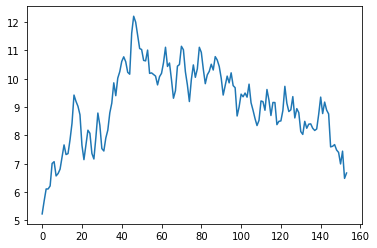

In [692]:
plt.plot(numpy.sqrt(era.groupby(era.time.dt.dayofyear).var().mean(['lat', 'lon'])))

In [1041]:
stds = [numpy.sqrt(numpy.mean([(o[mask_lowres] - means[i])**2 for o in obs_states[i*24:i*24+24]][15:])) for i in range(40)]

In [600]:
numpy.min(numpy.mean(opt_mps, axis=0))/numpy.mean(opt_mps, axis=0)[-1]

0.9973887

In [590]:
numpy.mean(errs_corr)*15, numpy.mean(errs_uncorr)*15

(91.27845525741577, 93.78516912460327)

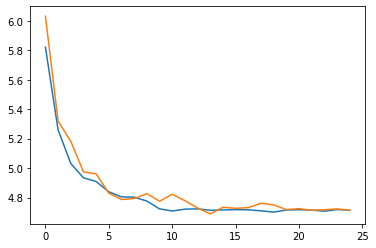

In [601]:
plt.plot(numpy.mean(opt_mps, axis=0))
plt.plot(numpy.mean(rand_mps, axis=0))

In [1]:
pc_radius = 1.0

true_pcs = []
fcst_pcs = []

initial_pcs_true = []
initial_pcs = []

all_true = []
all_fcst = []

for month in range(8, 9):
    for lead_time in range(0, 45):
        true_pcs = []
        fcst_pcs = []
        for year in range(1993, 2016):
            run_pc_fcst(year, month, lead_time, m_p)
        all_true.append(true_pcs)
        all_fcst.append(fcst_pcs)

NameError: name 'run_pc_fcst' is not defined

In [395]:
def bcorr(true, fcst):
    return sum(true[:, 0]*fcst[:, 0] + true[:, 1]*fcst[:, 1])/(numpy.sqrt(sum(true[:, 0]**2 + true[:, 1]**2))*numpy.sqrt(sum(fcst[:, 0]**2 + fcst[:, 1]**2)))

In [398]:
for i, lead_time in enumerate(range(0, 45)):
    print(bcorr(numpy.array(all_true[i]), numpy.array(all_fcst[i])))
    #print(numpy.sqrt(numpy.mean((numpy.array(all_true[i]) - numpy.array(all_fcst[i]))**2)))

0.806525988875785
0.7994038217832926
0.7924320863325697
0.7849024356686113
0.7768581987351364
0.7683282304615909
0.7593383967190444
0.7499020788774284
0.74020117157333
0.7302532754963353
0.7200339707219922
0.7097947168286131
0.6996131033933898
0.6896585182868894
0.6798554334307375
0.6702689035199849
0.6607966910122831
0.6519842825333371
0.6426781306407617
0.6337016592348722
0.624323417756184
0.6146208469080785
0.6047896627955187
0.5949878794879742
0.5849651986568821
0.5751775524854508
0.5650432830059411
0.5539736525273908
0.5435777673491959
0.5339822829098935
0.5251386214743258
0.5162784109973193
0.5084234806454571
0.500354811953665
0.492557049147564
0.48537500051917876
0.47816158241507095
0.4704419302381605
0.4630314840547781
0.45554035489211175
0.44843512327894575
0.44159914372393194
0.434215732695275
0.4272340492277797
0.4211892658100187


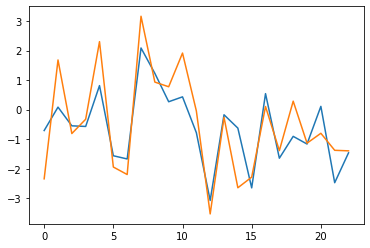

In [381]:
plt.plot(numpy.array(all_true[0])[:, 1])
plt.plot(numpy.array(all_fcst[0])[:, 1])

In [360]:
R = ((numpy.array(fcst_pcs).T - numpy.array(true_pcs).T)@(numpy.array(fcst_pcs).T - numpy.array(true_pcs).T).T)/23#numpy.cov(numpy.array(fcst_pcs).T - numpy.array(true_pcs).T)

In [361]:
R

array([[1.13214875, 0.1262185 ],
       [0.1262185 , 1.06275686]])

In [1423]:
numpy.std(true_pcs, axis=0)

array([1.05157802, 1.54978028])

In [1566]:
((numpy.array(fcst_pcs).T - numpy.array(true_pcs).T)@(numpy.array(fcst_pcs).T - numpy.array(true_pcs).T).T)/24

array([[0.19584798, 0.03919437],
       [0.03919437, 0.52529221]])

In [1450]:
numpy.linalg.inv(R)

array([[2.03168766, 0.08703887],
       [0.08703887, 0.90601821]])

In [1698]:
fcst = numpy.array(fcst_pcs)
nanmask = ~numpy.isnan(fcst)
true = numpy.array(true_pcs)
#true = numpy.random.randn(*fcst.shape)
numpy.corrcoef(true[nanmask], fcst[nanmask])[0, 1]

0.5785752653014016

In [1619]:
average_days

0

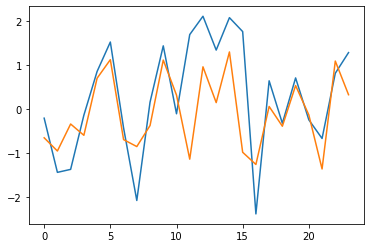

In [1699]:
plt.plot(true[:, 0])
plt.plot(fcst[:, 0])

In [2279]:
numpy.mean(errs_corr), numpy.mean(errs_uncorr)

(6.913454, 6.94401)

In [688]:
from sklearn.linear_model import LinearRegression

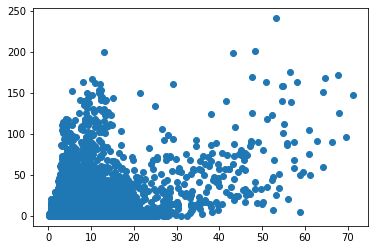

In [1708]:
plt.scatter(downscale(pred_corr[0])[mask], (obs_states[0] + clim_means[0].values)[mask])

In [1710]:
numpy.min((obs_states[1] + clim_means[1].values)[mask])

0.0

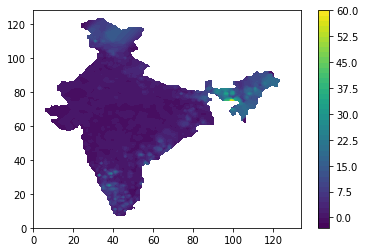

In [914]:
plt.contourf(obs_states[0] + clim_means[0].values, 40)
plt.colorbar()

In [ ]:
plt.contourf()

In [1044]:
corrs_land = []
uncorrs_land = []
for i in range(len(true_pcs)):
    #corr = numpy.corrcoef((downscale(pred_corr[i]) - clim_means[i].values)[mask], (obs_states[i])[mask])[0,1]
    corr_land = numpy.corrcoef(((pred_corr[i]) - (model_clims[i].values)).values[mask_lowres], obs_states[i][mask_lowres])[0,1]
    #uncorr = numpy.corrcoef((downscale(pred_uncorr[i]) - clim_means[i].values)[mask], obs_states[i][mask])[0,1]
    uncorr_land = numpy.corrcoef(((pred_uncorr[i]) - (model_clims[i].values)).values[mask_lowres], (obs_states[i])[mask_lowres])[0,1]
    corrs_land.append(corr_land)
    uncorrs_land.append(uncorr_land)
    print(uncorr_land, corr_land, corr_land/uncorr_land)

0.5609219308453361 0.558202415114777 0.9951517036845738
0.504611133760753 0.478820890815887 0.9488908563062074
0.21076174300377992 0.23083170650397586 1.0952258375460293
0.618922135730106 0.6107641106302338 0.9868189799186151
0.3305747502507651 0.45256941514730264 1.3690380611465203
0.2464407862021071 0.2401040832294648 0.9742871175250775
0.3878601625887883 0.4096372042592112 1.0561466316238077
0.30207746325268164 0.26449020871779366 0.875570808460322
0.394473390077864 0.42281984682869983 1.0718589833023735
0.23677203651991707 0.33880206979988675 1.430920960006977
0.20788460000469025 0.19144517331301517 0.9209204207944977
0.7017084755078781 0.6814582016079743 0.9711414716984185
0.1197115604177791 0.17747387935913791 1.4825124552697768
0.14823801399401185 0.16479170104511862 1.1116696494043388
0.43896611392286083 0.4132507643704158 0.9414183720865434
0.49862182492741186 0.5044048437128152 1.0115980057355998
0.496926500077607 0.44842274047430936 0.9023924874287794
0.6502807825240855 0.68

0.4791976893870565 0.4167950343621808 0.8697768031713693
0.012293675609347578 -0.02497362433450212 -2.0314204740780095
-0.01104218686729681 0.04760776116890304 -4.311443171633057
0.09630037973365319 0.27809302570875855 2.887766657596844
0.42351764060068514 0.37670109054719414 0.8894578511839791
0.3255479204914544 0.26246993998347845 0.8062405669409528
0.43213693840022593 0.4515445755811436 1.0449108499096718
0.1934518652899692 0.29586702965670936 1.5294090300614465
-0.33073282421493755 -0.2992300495662284 0.9047485694125236
-0.16278400673226714 -0.11596844695568163 0.7124068837205633
0.21659813955085316 0.24583177935563535 1.1349671786904647
0.37838168149571705 0.3096730183881 0.8184144041116992
0.12237299073424276 0.18668820170939968 1.525567043750938
-0.36724217721251606 -0.3605785613881565 0.9818549822492109
-0.023457296303265283 -0.27569529176071056 11.75307197370114
-0.0009348587928810497 -0.027993905006438037 29.944527686546508
0.373224920927346 0.3316156466766989 0.8885142124291

0.19512520838486486 0.19512525101792225 1.000000218490772
0.029042686822875946 0.029042652711557586 0.9999988254764937
-0.29903796434947066 -0.29903801879974873 1.0000001820848339
0.22039468810156482 0.22039470204646514 1.0000000632723975
0.30892517668740127 0.3089252053421885 1.0000000927564
0.6308469797089378 0.6308470065973624 1.0000000426227365
-0.14257368626570888 -0.14257376327949953 1.0000005401683345
0.3725027952811366 0.37250276595741 0.999999921279177
0.6224640439611839 0.6224640313164087 0.9999999796859347
0.23783783242524514 0.23783795858833007 1.0000005304584374
-0.013770375747186515 -0.01377039407226825 1.0000013307611986
0.36557198840908806 0.3655720658663331 1.0000002118795956
0.263565439461656 0.26356546175247364 1.0000000845741297
0.3486811373485033 0.3486811724245812 1.0000001005964307
0.16086801187255462 0.16086801193742564 1.0000000004032563
-0.28769143575403955 -0.28769150503515056 1.000000240817426
0.6019455433550799 0.6019456152569007 1.000000119449046
0.3925031

0.3173773829417673 0.3404629288929626 1.0727384722163111
0.25396703629135225 0.46575455188255543 1.8339173409427807
0.46818962284836685 0.5300719378095158 1.132173615008103
0.18523014888542422 0.22119850379317593 1.1941819683468498
0.02510934972978985 0.16684155862523914 6.644598941058897
0.31188747045563936 0.3610466368366692 1.1576182791479657
0.16243115301167052 0.13079121038064848 0.8052101333741765
0.5558641150097784 0.6254405432448008 1.1251680516087974
0.30612554631441097 0.301462068278379 0.9847661258846975
0.3896540883117665 0.38573485576830213 0.9899417646034588
0.427058919309104 0.4198906860703684 0.9832148846104599
0.1541364007107507 0.19661709983791167 1.2756045874386248
0.301126212119211 0.3476810971075193 1.1546025656839134
0.20753737692107552 0.21528709404521745 1.0373413080530987
0.38967418965549766 0.36747556220176936 0.9430328514358274
0.39661803214561614 0.43882404889072374 1.1064147701928284
0.21338775197301288 0.03657611883667643 0.17140683332800752
0.165927308484

-0.25683378221901376 -0.23380942181003977 0.9103530687822832


In [1045]:
corrs = []
uncorrs = []
for i in range(len(true_pcs)):
    #corr = numpy.corrcoef((downscale(pred_corr[i]) - clim_means[i].values)[mask], (obs_states[i])[mask])[0,1]
    corr = numpy.corrcoef(((pred_corr[i]) - (model_clims[i].values)).values, obs_states[i])[0,1]
    #uncorr = numpy.corrcoef((downscale(pred_uncorr[i]) - clim_means[i].values)[mask], obs_states[i][mask])[0,1]
    uncorr = numpy.corrcoef(((pred_uncorr[i]) - (model_clims[i].values)).values, (obs_states[i]))[0,1]
    corrs.append(corr)
    uncorrs.append(uncorr)
    print(uncorr, corr, corr/uncorr)

0.9504791967971081 0.9436086588336656 0.9927715009580488
0.6156682594152042 0.664958853933278 1.0800603145676095
0.4478597983467266 0.4095060039656846 0.9143620514218401
0.7194206042262266 0.7363692352386989 1.0235587233850516
0.9367199486966811 0.9281229782407913 0.9908222617999635
0.8928111938237135 0.8693260479862889 0.9736952829446023
0.5834534652979878 0.5446493556599545 0.9334923658081029
0.7597472302045141 0.7642228635837575 1.0058909505705451
0.9435475507408602 0.9487036677018253 1.0054646074349054
0.6685125381822332 0.6508719083027785 0.9736121181400401
0.5792150464904535 0.6067583063744023 1.0475527354664513
0.4331772361876227 0.4994246583562112 1.1529337569804676
0.9441557634338231 0.9443994878217736 1.000258140020312
0.5411702417987461 0.5663284944947642 1.0464886107048255
0.8629569609215494 0.8437492991795629 0.9777420397403427
0.7400776454903599 0.7620480330561646 1.0296865980207355
0.8721155700672371 0.8824173523049657 1.01181240490516
0.7957677473311114 0.77619078030392

0.8710822622102898 0.8433324633032975 0.9681433084900847
0.7594560592092001 0.7608108248620769 1.0017838631168305
0.7540998411076146 0.7471383262118876 0.9907684440226084
0.837449451490521 0.8312757450711618 0.9926279652958503
0.6434845038862839 0.579178859256946 0.9000665218183685
0.916271489853986 0.9104052568390631 0.9935977130360591
0.6408874037648528 0.6256840796747601 0.976277698702172
0.7595193495093898 0.7415182272521852 0.9762993236856541
0.43807196402219833 0.41813134648800954 0.95448095479313
0.3785444736204104 0.37241988219950095 0.9838206819866272
0.5969958989727009 0.1941171720492206 0.3251566256707185
0.8098714677804222 0.8115858925253524 1.0021169096741103
0.5987019189521762 0.6160066481643217 1.0289037476987406
0.9256571047559479 0.9104431766749138 0.9835641859141293
0.8795640491719816 0.8840087421618393 1.0050532908820478
0.8212822806515081 0.7201173816476223 0.8768207942783892
0.8909005887783845 0.881971869663803 0.9899778726975311
0.8132650788221498 0.83580537427764

0.604340511960122 0.6043405327361132 1.0000000343779556
0.7042182297767575 0.7042182297767575 1.0
0.7887224872525045 0.7887226078450402 1.0000001528960283
0.7511692280460031 0.7511694376248067 1.0000002790034466
0.7701759676311151 0.7701759676311151 1.0
0.8903058463005373 0.8903058147513229 0.9999999645636221
0.7416751729014718 0.7416751729014718 1.0
0.48381595073388955 0.48381595073388955 1.0
0.686279038302288 0.686279038302288 1.0
0.7936975241528236 0.7936974569754909 0.9999999153615443
0.8507738983245207 0.8507738983245207 1.0
0.7424319892974334 0.742431989826656 1.0000000007128231
0.9309674176814103 0.9309674176814103 1.0
0.6935087776264837 0.6935087776264837 1.0
0.7472119452944436 0.7472119452944436 1.0
0.9120505514661708 0.9120505514661708 1.0
0.619343450844764 0.619343450844764 1.0
0.6804091250238385 0.6804091352101213 1.0000000149708201
0.8102866392722369 0.8102866392722369 1.0
0.7651224257531596 0.765122406495524 0.9999999748306481
0.48093633503126787 0.48093633503126787 1.0
0

0.8959504374017679 0.8445063438028944 0.9425815408405178
0.6597685189161173 0.6930518875943337 1.0504470397176497
0.6431966647219463 0.5780879330720737 0.8987732132006327
0.7592232548014948 0.7574006735646787 0.9975994133144768
0.8731836806959035 0.8031455853785926 0.9197899630218782
0.7061677158464242 0.7339707294388913 1.0393716860294893
0.7626001679634431 0.6670255417402373 0.8746726918793606
0.8266743210012863 0.8257413506407436 0.9988714172717827
0.6613905532835026 0.6078740421203855 0.9190848570524148
0.8973334782205771 0.868397683385145 0.9677535770839487
0.7109100892499177 0.6570922746280277 0.9242972980188349
0.9334159826508706 0.9138381590704635 0.9790256177906803
0.6854510737582855 0.6983111340598945 1.0187614562059084
0.7018842427155266 0.6498668532738308 0.9258889339922417
0.6448524257320145 0.637112221668999 0.9879969373547302
0.6648653245938769 0.6634569807589707 0.9978817607373848
0.7744760741358094 0.7463367148811443 0.963666586748901
0.8683210521601061 0.8523644538115

0.5254622469349636 0.5742079976715267 1.0927673701029874
0.7630022419259379 0.7741629732484633 1.0146273899462652
0.2506930152200958 0.2769070329147315 1.1045662068870212
0.5517518072466859 0.549509425360846 0.9959358866497788
0.5516406182621955 0.5744161583924878 1.0412869164747893
0.5536069084399905 0.6272643115319498 1.1330500070880953
0.8257506523353914 0.8391153758123061 1.0161849384425148
0.38415669914400186 0.2096276833549341 0.5456827482692285
0.9009967724673296 0.9106682866017234 1.010734238379022
0.8131449524139621 0.8228712745164709 1.0119613631907012
0.8911910617067643 0.9105203452185057 1.0216892699470335
0.9010639427036028 0.8922324812517298 0.9901988515649904
0.6940208820591125 0.5440779705425276 0.7839504323389888
0.5940964130005738 0.4535359464405767 0.7634046200513563
0.8112443537835364 0.8055281861463172 0.9929538275236557
0.6756978527375539 0.7053700343516348 1.0439133874613715
0.7816698533559449 0.7431896958995151 0.9507718542665772
0.9494442410887605 0.95264758184

In [1046]:
rmse_corrs = []
rmse_uncorrs = []
for i in range(len(true_pcs)):
    #corr = numpy.corrcoef((downscale(pred_corr[i]) - clim_means[i].values)[mask], (obs_states[i])[mask])[0,1]
    rmse_corr = numpy.sqrt(numpy.mean((((pred_corr[i]) - (model_clims[i].values)).values - obs_states[i])**2))
    #uncorr = numpy.corrcoef((downscale(pred_uncorr[i]) - clim_means[i].values)[mask], obs_states[i][mask])[0,1]
    rmse_uncorr = numpy.sqrt(numpy.mean((((pred_uncorr[i]) - (model_clims[i].values)).values - obs_states[i])**2))
    rmse_corrs.append(rmse_corr)
    rmse_uncorrs.append(rmse_uncorr)
    print(rmse_uncorr, rmse_corr, rmse_corr/rmse_uncorr)

6.1529727 6.0962343 0.9907787
7.631203 7.808078 1.0231779
4.190894 4.1258535 0.9844805
6.0861344 6.159812 1.0121058
7.8712444 7.5513663 0.9593612
5.1595693 5.144943 0.99716526
5.340446 5.3125305 0.9947728
5.1310406 5.201518 1.0137355
6.642971 6.6591735 1.002439
5.548946 5.3528624 0.9646629
6.4299164 6.4621916 1.0050195
5.783376 5.8358893 1.00908
5.952317 5.8639097 0.98514736
6.4371924 6.4438486 1.001034
5.622375 5.6340623 1.0020787
4.1348033 4.1939583 1.0143065
5.9581122 6.1321983 1.0292183
4.1828833 4.1295786 0.98725647
4.064712 4.0849323 1.0049746
4.8063874 4.837464 1.0064657
4.7640395 4.8365383 1.0152179
5.07574 5.176773 1.0199051
5.274672 5.2360635 0.9926804
6.2782464 6.28277 1.0007205
5.7280464 5.7285614 1.0000899
6.8524027 7.0636854 1.0308334
4.4042263 4.494994 1.0206093
6.134529 6.14802 1.0021992
7.792989 7.665767 0.9836749
5.45273 5.3148146 0.97470707
5.7914734 5.823405 1.0055135
4.9045415 4.9707203 1.0134934
6.23498 6.1589785 0.98781043
5.1669765 4.960473 0.960034
6.54401 6.45

7.7798886 7.779889 1.0000001
7.1314726 7.1314726 1.0
6.583209 6.583209 1.0
5.967392 5.967392 1.0
6.3016586 6.3016586 1.0
5.5078197 5.5078197 1.0
5.346187 5.346187 1.0
10.333463 10.333463 1.0
4.7961593 4.7961593 1.0
6.39325 6.39325 1.0
4.4228535 4.4228535 1.0
6.208982 6.208982 1.0
7.952129 7.952129 1.0
6.7853804 6.7853804 1.0
5.7420664 5.742067 1.0000001
5.7454996 5.7454996 1.0
5.3007536 5.3007536 1.0
5.19707 5.19707 1.0
6.104662 6.104662 1.0
7.861958 7.861958 1.0
4.4846573 4.4846573 1.0
8.278928 8.278928 1.0
5.6977053 5.6977053 1.0
7.087653 7.087653 1.0
8.012434 8.012434 1.0
6.714567 6.714567 1.0
6.530439 6.530439 1.0
6.2034945 6.2034945 1.0
6.2197876 6.2197876 1.0
6.0219064 6.0219064 1.0
5.546987 5.546987 1.0
11.470969 11.470969 1.0
4.8153787 4.8153787 1.0
6.2656455 6.2656455 1.0
4.664021 4.664021 1.0
6.2113953 6.2113953 1.0
7.5609803 7.5609803 1.0
6.699395 6.699395 1.0
5.5250278 5.5250278 1.0
5.685888 5.685888 1.0
5.2709 5.2709 1.0
5.4267673 5.4267673 1.0
5.854907 5.8549075 1.0000001

5.2754216 5.298884 1.0044475
4.1266994 3.9682097 0.9615941
4.126509 4.1566753 1.0073104
6.4001803 6.507228 1.0167257
5.277258 5.580278 1.05742
3.601115 3.5110822 0.97499865
5.014039 4.9950786 0.9962185
6.2735715 6.067227 0.9671089
4.203115 4.2149153 1.0028075
5.6464987 5.8716636 1.0398769
4.718235 4.8805203 1.0343953
5.023702 4.999202 0.995123
5.1060576 4.8356404 0.9470399
5.5081086 5.3995366 0.9802887
4.779316 4.659792 0.9749914
4.902972 4.811972 0.9814398
4.2075143 4.12674 0.98080236
5.36983 5.4210515 1.0095388
6.191274 6.1288977 0.9899251
5.4564333 5.301504 0.97160614
4.511352 4.46535 0.9898031
5.3417416 5.4331007 1.0171028
4.793609 4.79213 0.9996914
5.6632986 5.308652 0.93737805
5.1106043 5.2352185 1.0243834
4.13696 3.951658 0.9552082
4.4214034 4.355568 0.9851098
6.110843 6.2417984 1.02143
4.918202 5.2935133 1.0763106
3.4331672 3.4311092 0.99940056
5.0176578 4.910413 0.9786265
6.642485 6.758862 1.0175201
3.9247136 4.065083 1.0357655
5.7378507 5.897151 1.027763
4.381884 4.5460863 1.

Text(0.5, 0.98, 'RMSE, 15-day rainfall over monsoon region')

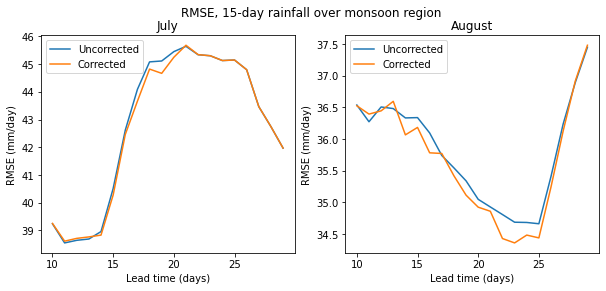

In [1054]:
plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
plt.plot(range(10, 30), 7*numpy.array(rmse_uncorrs).reshape(40, 24).mean(axis=1)[:20])
plt.plot(range(10, 30), 7*numpy.array(rmse_corrs).reshape(40, 24).mean(axis=1)[:20])
plt.legend(["Uncorrected", "Corrected"])
plt.xlabel("Lead time (days)")
plt.ylabel("RMSE (mm/day)")
plt.title('July')
plt.subplot(1, 2, 2)
plt.plot(range(10, 30), 7*numpy.array(rmse_uncorrs).reshape(40, 24).mean(axis=1)[20:40])
plt.plot(range(10, 30), 7*numpy.array(rmse_corrs).reshape(40, 24).mean(axis=1)[20:40])
plt.legend(["Uncorrected", "Corrected"])
plt.xlabel("Lead time (days)")
plt.ylabel("RMSE (mm/day)")
plt.title('August')

plt.suptitle("RMSE, 15-day rainfall over monsoon region")

Text(0.5, 0.98, 'RMSE, 15-day rainfall over India')

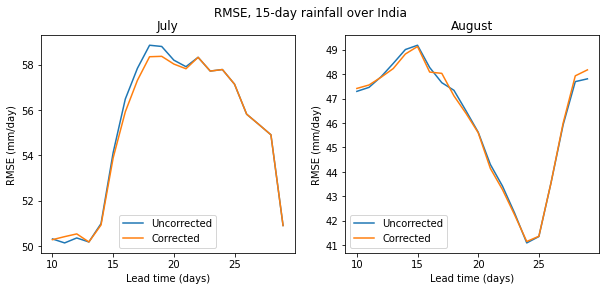

In [1055]:
plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
plt.plot(range(10, 30), [numpy.mean(e)*7 for e in all_errs_uncorr[:20]])
plt.plot(range(10, 30), [numpy.mean(e)*7 for e in all_errs_corr[:20]])
plt.legend(["Uncorrected", "Corrected"])
plt.xlabel("Lead time (days)")
plt.ylabel("RMSE (mm/day)")
plt.title('July')
plt.subplot(1, 2, 2)
plt.plot(range(10, 30), [numpy.mean(e)*7 for e in all_errs_uncorr[20:40]])
plt.plot(range(10, 30), [numpy.mean(e)*7 for e in all_errs_corr[20:40]])
plt.legend(["Uncorrected", "Corrected"])
plt.xlabel("Lead time (days)")
plt.ylabel("RMSE (mm/day)")
plt.title('August')

plt.suptitle("RMSE, 15-day rainfall over India")

Text(0.5, 0.98, 'Spatial correlation, rainfall over India')

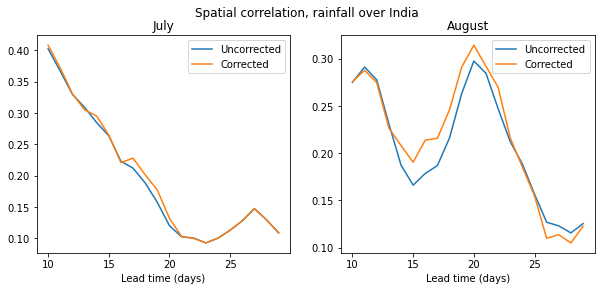

In [1049]:
plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
plt.plot(range(10, 30), numpy.array(uncorrs_land).reshape(40, 24).mean(axis=1)[:20])
plt.plot(range(10, 30), numpy.array(corrs_land).reshape(40, 24).mean(axis=1)[:20])
plt.legend(["Uncorrected", "Corrected"])
plt.xlabel("Lead time (days)")
plt.title('July')
plt.subplot(1, 2, 2)
plt.plot(range(10, 30), numpy.array(uncorrs_land).reshape(40, 24).mean(axis=1)[20:40])
plt.plot(range(10, 30), numpy.array(corrs_land).reshape(40, 24).mean(axis=1)[20:40])
plt.legend(["Uncorrected", "Corrected"])
plt.xlabel("Lead time (days)")
plt.title('August')

plt.suptitle("Spatial correlation, rainfall over India")

Text(0.5, 0.98, 'Spatial correlation, rainfall over monsoon region')

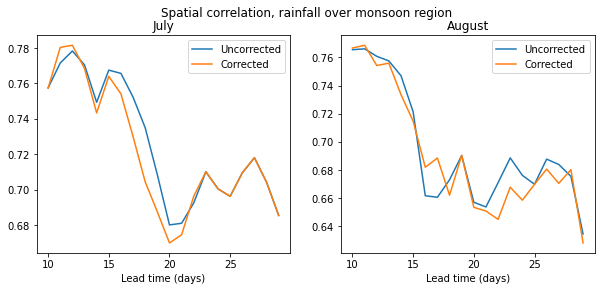

In [1050]:
plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
plt.plot(range(10, 30), numpy.array(uncorrs).reshape(40, 24).mean(axis=1)[:20])
plt.plot(range(10, 30), numpy.array(corrs).reshape(40, 24).mean(axis=1)[:20])
plt.legend(["Uncorrected", "Corrected"])
plt.xlabel("Lead time (days)")
plt.title('July')
plt.subplot(1, 2, 2)
plt.plot(range(10, 30), numpy.array(uncorrs).reshape(40, 24).mean(axis=1)[20:40])
plt.plot(range(10, 30), numpy.array(corrs).reshape(40, 24).mean(axis=1)[20:40])
plt.legend(["Uncorrected", "Corrected"])
plt.xlabel("Lead time (days)")
plt.title('August')

plt.suptitle("Spatial correlation, rainfall over monsoon region")

In [45]:
corr_means_land = numpy.array([numpy.mean((pred_corr[i] - model_clims[i]).values[mask_lowres]) for i in range(len(pred_corr))]).reshape(-1, 24)
uncorr_means_land = numpy.array([numpy.mean((pred_uncorr[i] - model_clims[i]).values[mask_lowres]) for i in range(len(pred_uncorr))]).reshape(-1, 24)
obs_means_land = numpy.array([numpy.mean(p[mask_lowres]) for p in obs_states]).reshape(-1, 24)

corr_means = numpy.array([numpy.mean((pred_corr[i] - model_clims[i]).values) for i in range(len(pred_corr))]).reshape(-1, 24)
uncorr_means = numpy.array([numpy.mean((pred_uncorr[i] - model_clims[i]).values) for i in range(len(pred_uncorr))]).reshape(-1, 24)
obs_means = numpy.array([numpy.mean(p) for p in obs_states]).reshape(-1, 24)

In [46]:
numpy.corrcoef(corr_means[0], obs_means[0]), numpy.corrcoef(uncorr_means[0], obs_means[0])

(array([[1.        , 0.60940433],
        [0.60940433, 1.        ]]),
 array([[1.        , 0.52303777],
        [0.52303777, 1.        ]]))

Text(0.5, 0.98, 'Temporal correlation, whole monsoon region rainfall')

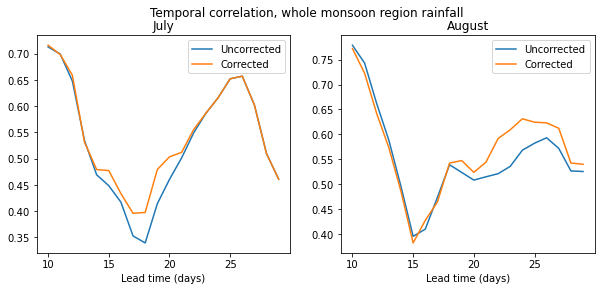

In [1052]:
plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
plt.plot(range(10, 30), [numpy.corrcoef(uncorr_means[i, :], obs_means[i, :])[0, 1] for i in range(20)])
plt.plot(range(10, 30), [numpy.corrcoef(corr_means[i, :], obs_means[i, :])[0, 1] for i in range(20)])
plt.legend(["Uncorrected", "Corrected"])
plt.xlabel("Lead time (days)")
plt.title('July')
plt.subplot(1, 2, 2)
plt.plot(range(10, 30), [numpy.corrcoef(uncorr_means[i, :], obs_means[i, :])[0, 1] for i in range(20, 40)])
plt.plot(range(10, 30), [numpy.corrcoef(corr_means[i, :], obs_means[i, :])[0, 1] for i in range(20, 40)])
plt.legend(["Uncorrected", "Corrected"])
plt.xlabel("Lead time (days)")
plt.title('August')

plt.suptitle("Temporal correlation, whole monsoon region rainfall")

Text(0.5, 0.98, 'Temporal correlation, all-India rainfall')

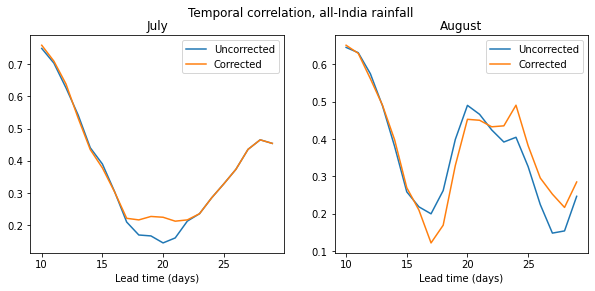

In [1053]:
plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
plt.plot(range(10, 30), [numpy.corrcoef(uncorr_means_land[i, :], obs_means_land[i, :])[0, 1] for i in range(20)])
plt.plot(range(10, 30), [numpy.corrcoef(corr_means_land[i, :], obs_means_land[i, :])[0, 1] for i in range(20)])
plt.legend(["Uncorrected", "Corrected"])
plt.xlabel("Lead time (days)")
plt.title('July')
plt.subplot(1, 2, 2)
plt.plot(range(10, 30), [numpy.corrcoef(uncorr_means_land[i, :], obs_means_land[i, :])[0, 1] for i in range(20, 40)])
plt.plot(range(10, 30), [numpy.corrcoef(corr_means_land[i, :], obs_means_land[i, :])[0, 1] for i in range(20, 40)])
plt.legend(["Uncorrected", "Corrected"])
plt.xlabel("Lead time (days)")
plt.title('August')

plt.suptitle("Temporal correlation, all-India rainfall")

In [818]:
corr_means.shape

(40, 24)

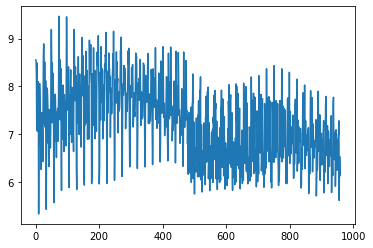

In [787]:
plt.plot([numpy.mean(p).values.reshape() for p in pred_corr])

In [775]:
len(corrs)/40

24.0

In [767]:
numpy.mean(corrs)/numpy.mean(uncorrs)

1.0453991543803367

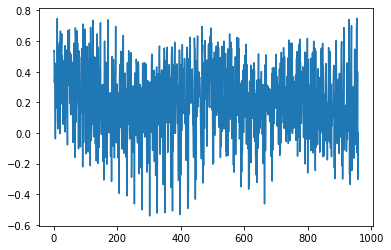

In [768]:
plt.plot(corrs)

In [1932]:
for month in range(8, 9):
    for lead_time in range(5, 6):
        for year in range(1993, 2017):
            run_sel(year, month, lead_time)

Year:  1993
Year:  1994
Year:  1995
Year:  1996
Year:  1997
Year:  1998
Year:  1999
Year:  2000
Year:  2001
Year:  2002
Year:  2003
Year:  2004
Year:  2005
Year:  2006
Year:  2007
Year:  2008
Year:  2009
Year:  2010
Year:  2011
Year:  2012
Year:  2013
Year:  2014
Year:  2015
Year:  2016


In [576]:
numpy.mean(errs_uncorr)

5.34362

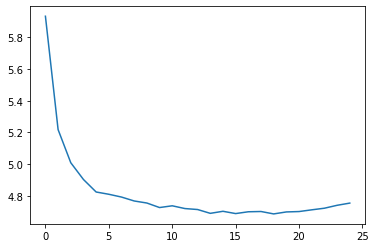

In [52]:
plt.plot(numpy.mean(opt_mps, axis=0))

In [90]:
uncorrs = []
for i in range(len(errs_uncorr)):
    #corr = numpy.corrcoef((downscale(pred_corr[i]) - clim_means[i].values)[mask], (obs_states[i])[mask])[0,1]
    #uncorr = numpy.corrcoef((downscale(pred_uncorr[i]) - clim_means[i].values)[mask], obs_states[i][mask])[0,1]
    uncorr = numpy.corrcoef((numpy.flipud(pred_uncorr[i]) - upscale(clim_means_averaged[i].values))[mask_lowres], (obs_states[i])[mask_lowres])[0,1]
    uncorrs.append(uncorr)
    print(uncorr)

0.3065686361098131
-0.13900165321808983
0.029175710698868297
-0.05099473013012325
0.03628131141821727
0.18990499554804427
0.03820700389657133
0.04590191650732673
0.23517494118565901
0.5131869612808643
-0.004650147884129541
0.3053582107079308
0.2168159288590112
0.31489854145086443
0.42302359453256777
0.3887970292026647
0.05754981492712893
0.19915643198606017
0.4032832439563656
0.2902619223421006
0.22908895639137702
-0.0037847622891708575
0.47799125742654436
0.2031331401259013


In [1854]:
mask_lowres = ~numpy.isnan(upscale(obs_states[0]))

In [595]:
numpy.mean(corrs), numpy.mean(uncorrs)

(0.2534947360621707, 0.21520387038270353)

In [868]:
[numpy.corrcoef(ens_errs[i], ens_dists[i])[0,1] for i in range(len(ens_errs))]

[0.08995832345668629,
 0.010064912229956598,
 0.028348677551189652,
 -0.08142476141459566,
 0.5096442374846567,
 0.2458517146430362,
 -0.13402438899300298,
 -0.02092590286781511,
 -0.3599995058500078,
 0.10335931850234768,
 0.007098239370473052,
 -0.024631347925605555,
 -0.16816279129252423,
 0.14925862010305085,
 0.15290776153640906,
 -0.07204204718470143,
 0.1893512209949106,
 0.3589965974457043,
 -0.2739704533058002,
 0.21483303972095133,
 0.08995832345668629,
 0.010064912229956598,
 0.028348677551189652,
 0.08995832345668629,
 0.08995832345668629,
 0.010064912229956598,
 0.028348677551189652,
 -0.08142476141459566,
 0.5096442374846567,
 0.2458517146430362,
 -0.13402438899300298,
 -0.02092590286781511,
 -0.3599995058500078,
 0.10335931850234768,
 0.007098239370473052,
 -0.024631347925605555,
 -0.16816279129252423,
 0.14925862010305085,
 0.15290776153640906,
 -0.07204204718470143,
 0.1893512209949106,
 0.3589965974457043,
 -0.2739704533058002,
 0.21483303972095133,
 nan,
 -0.10639054

In [1367]:
nanmask = numpy.isnan(numpy.ravel(ens_dists))
numpy.corrcoef(numpy.ravel(ens_errs)[~nanmask], numpy.ravel(ens_dists)[~nanmask])

array([[1.        , 0.07454377],
       [0.07454377, 1.        ]])

In [745]:
lin_model = LinearRegression().fit(numpy.ravel(ens_dists).reshape(-1,1), numpy.ravel(ens_errs))

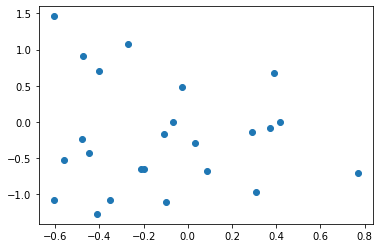

In [1197]:
plt.scatter(numpy.array(initial_pcs)[:, 0][:, 1], numpy.array(initial_pcs_true)[:, 1])

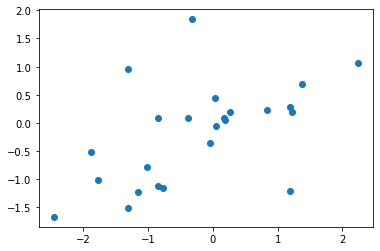

In [1707]:
plt.scatter(numpy.array(true_pcs)[:, 1], numpy.array(fcst_pcs)[:, 1])

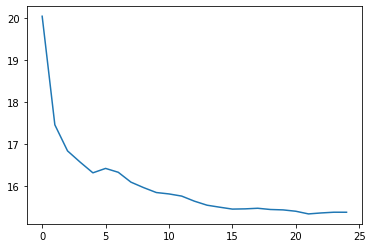

In [1828]:
plt.plot(numpy.mean(opt_mps, axis=0))

In [1706]:
min(numpy.mean(opt_mps[:130], axis=0))/numpy.mean(opt_mps[:130], axis=0)[-1]

0.997455881608937

In [726]:
min(numpy.mean(opt_mps[:130], axis=0))/numpy.mean(opt_mps[:130], axis=0)[-1]

0.9932142188940619

In [240]:
len(opt_mps)

794

In [236]:
obs['p'].groupby('dayofyear').std(dim=["time", "lat", "lon"])[60:].mean()

<xarray.DataArray 'p' ()>
array(12.9528, dtype=float32)

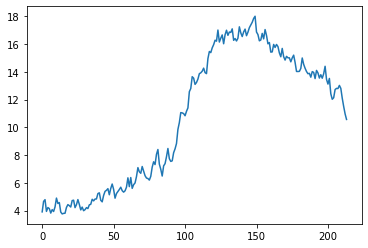

In [233]:
plt.plot(obs['p'].groupby('dayofyear').std(dim=["time", "lat", "lon"]))

In [370]:
obs_data

<xarray.DataArray 'p' (time: 31900, lat: 129, lon: 135)>
[555538500 values with dtype=float32]
Coordinates:
  * lon        (lon) float64 66.5 66.75 67.0 67.25 ... 99.25 99.5 99.75 100.0
  * lat        (lat) float64 6.5 6.75 7.0 7.25 7.5 ... 37.75 38.0 38.25 38.5
  * time       (time) datetime64[ns] 1901-03-01 1901-03-02 ... 2016-11-30
    dayofyear  (time) object ...

In [110]:
numpy.corrcoef(downscale(pred_corr[0])[mask], obs_states[0][mask])

ValueError: different number of values and points

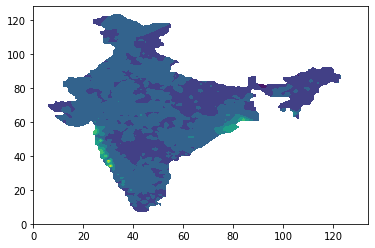

In [76]:
plt.contourf(obs_states[0])

In [ ]:
mp = numpy.argmin(numpy.mean(numpy.vstack(opt_mps), axis=0)) + 1

opt_mps = []
true_pcs = []
fcst_pcs = []
pred_corr = []
pred_uncorr = []
ens_corr = []
ens_uncorr = []
obs_states = []
clim_means = []

for year in range(1998, 2017):
    run_enoc(year, month, lead_time, m_p)

with open("res_fcst_" + str(sys.argv[1]), "wb") as pickle_file:
    pickle.dump([opt_mps, true_pcs, fcst_pcs, pred_corr, pred_uncorr, ens_corr, ens_uncorr, obs_states, clim_means, mp],
                pickle_file)

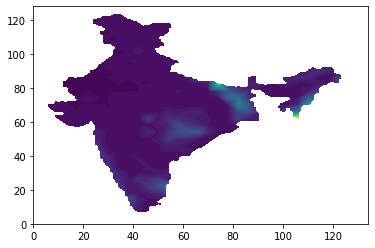

In [38]:
plt.contourf(downscale(model['prec'][20, 10, 20, :, :]), 40)

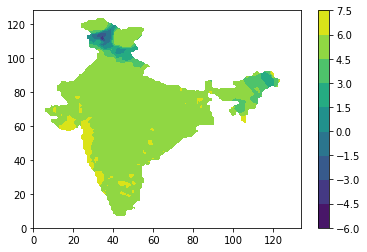

In [49]:
plt.contourf(downscale(model['prec'][20, 10, 20, :, :]) + 6 - clim_mean['p'].isel(dayofyear=0).values)
plt.colorbar()

In [91]:
clim_mean['p'].isel(dayofyear=range(0,10)).mean('dayofyear')

<xarray.DataArray 'p' (lat: 129, lon: 135)>
array([[nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       ...,
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan]], dtype=float32)
Coordinates:
  * lon      (lon) float64 66.5 66.75 67.0 67.25 67.5 ... 99.25 99.5 99.75 100.0
  * lat      (lat) float64 6.5 6.75 7.0 7.25 7.5 ... 37.5 37.75 38.0 38.25 38.5

In [325]:
miso = xarray.open_dataarray('miso_index.nc').values

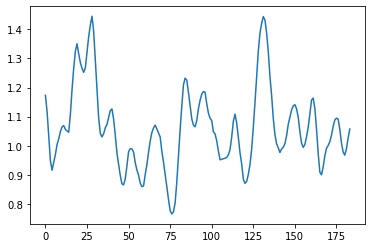

In [333]:
plt.plot(numpy.std(miso[:, :, 0], axis=0))

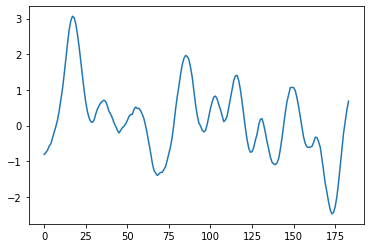

In [329]:
plt.plot(miso[0, :, 0])

In [477]:
miso2 = miso[:-5, :, :]

In [1112]:
eeof_pcs2 = eeof_pcs.reshape((79, 107, 2))
eeof_pcs3 = eeof_pcs2[:-5, :, :]

In [1126]:
miso_radius = 10000

def forecast_miso(initial_pcs, lead_time, k):
    pc_dist = numpy.sqrt(numpy.sum((eeof_pcs3 - initial_pcs)**2, axis=2))
    idx2 = numpy.unravel_index(numpy.argsort(pc_dist.ravel()), pc_dist.shape)
    idx2 = (idx2[0][:k], idx2[1][:k])
    day_dists = (idx2[1][1:] - idx2[1][:-1])
    year_dists = (idx2[0][1:] - idx2[0][:-1])
    too_close = numpy.where((year_dists == 0) & (day_dists <= 10))[0] + 1
    too_close_mask = numpy.ones(idx2[1].shape, dtype=bool)
    too_close_mask[too_close] = False
    same_year = (idx2[1] + lead_time) < 107
    dist_mask = pc_dist[idx2[0], idx2[1]] <= miso_radius
    dists = pc_dist[idx2[0][same_year & too_close_mask & dist_mask], idx2[1][same_year & too_close_mask & dist_mask]]
    pcs_fcst = (eeof_pcs3[idx2[0][same_year & too_close_mask & dist_mask], idx2[1][same_year & too_close_mask & dist_mask] + lead_time, :]/dists.reshape(-1, 1)).sum(axis=0)/sum(1/dists.reshape(-1, 1))
    return pcs_fcst

In [1190]:
t_i = 20
y = -3
forecast_length = 70
init = eeof_pcs2[y, t_i, :]
forecast = numpy.array([forecast_miso(init, i, 15) for i in range(0, forecast_length)])
#plt.plot([forecast_miso(init, i, 10)[0] for i in range(1, 80)], [forecast_miso(init, i, 10)[1] for i in range(1, 80)])
truth = eeof_pcs2[y, t_i:t_i+forecast_length, :]

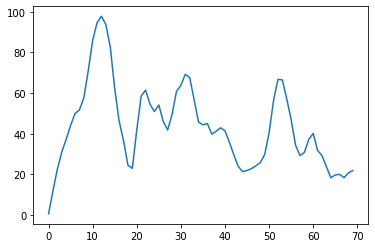

In [1191]:
plt.plot(numpy.sqrt(numpy.mean((forecast - truth)**2, axis=1)))

In [1185]:
numpy.sqrt(numpy.mean(eeof_pcs2.var(axis=(0,1))))

70.14312

In [390]:
new_obs = obs.sel(time=(obs.time.dt.month >= 6))['p'].mean('lon')

NameError: name 'obs' is not defined

In [1038]:
new_dat = new_obs.isel(lat=range(7, 124))

In [1078]:
samples = numpy.array([numpy.hstack([new_dat.sel(time=new_dat.time.dt.year == year).isel(time=i).values for i in range(start_day - 15, start_day)]) for year in range(1901, 1980) for start_day in range(15, 122)])

In [1045]:
samples2 = numpy.array([numpy.hstack([new_dat.sel(time=new_dat.time.dt.year == year).isel(time=i).values for i in range(start_day - 15, start_day)]) for start_day in range(15, 122) for year in range(2008, 2009)])

In [1040]:
mean = samples.mean(axis=0)
evals, evecs = numpy.linalg.eig((samples - mean).T@(samples - mean)/samples.shape[0])

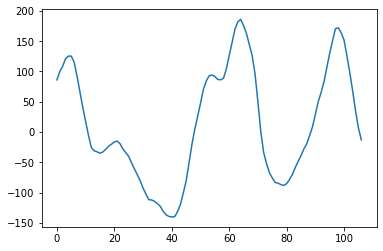

In [1071]:
plt.plot((samples2 - mean)@evecs[:, 0])
#plt.plot(samples2@evecs[:, 1])

In [1007]:
samples2.shape

(107, 1755)

In [1081]:
eeof_pcs = (samples - mean)@evecs[:, :2]

In [1089]:
pickle.dump(eeof_pcs, open('pcs_eeof', 'wb'))

In [1090]:
pickle.dump(evals, open('evals_eeof', 'wb'))

In [1091]:
pickle.dump(evecs, open('evecs_eeof', 'wb'))

In [1111]:
pickle.dump(mean, open('mean_eeof', 'wb'))

In [1809]:
x = xarray.open_dataarray('x_training_future.nc')                                      
pcs_training = xarray.open_dataarray('pcs_training_future.nc')                                  
                                                                                
X_train, X_test, y_train, y_test = train_test_split(x, pcs_training, shuffle=False) 

In [1748]:
from sklearn.model_selection import train_test_split

In [1810]:
X_test = scaler_future.transform(X_test)

In [1811]:
y_pred = nn_model_future(X_test)

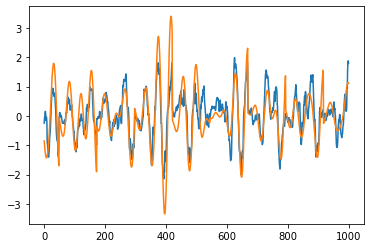

In [1813]:
plt.plot(y_pred[:1000, 0])
plt.plot(y_test[:1000, 0])

In [1765]:
numpy.mean(y_test**2)

<xarray.DataArray ()>
array(1.03288144)

In [1770]:
pcs2.shape

(116, 153, 2)

In [2]:
import matplotlib.pyplot as plt

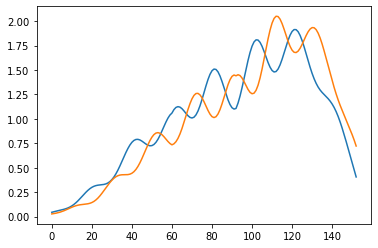

In [5]:
plt.plot(pcs2.var(axis=0))

In [34]:
pc_mean_may = numpy.mean(pcs2[:, 0, :], axis=0)

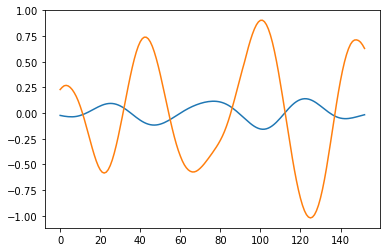

In [23]:
plt.plot(pcs2.mean(axis=0)[:, 0])
plt.plot(pcs2[4, :, 0])

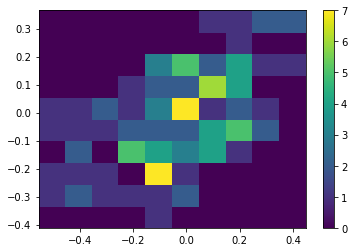

In [32]:
plt.hist2d(pcs2[:, 0, 0], pcs2[:, 0, 1], 10)
plt.colorbar()

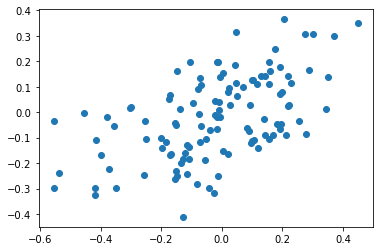

In [1796]:
plt.scatter(pcs2[:, 0, 0], pcs2[:, 0, 1])

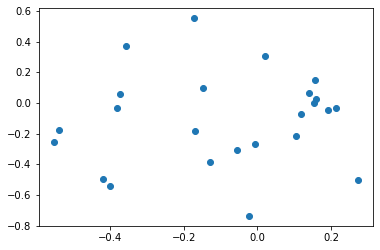

In [1806]:
plt.scatter(numpy.array(initial_pcs_true)[:, 0], numpy.array(initial_pcs)[:, 0, 0])

In [2134]:
era = xarray.open_dataset('../era5_prec_anomalies.nc')['tp'].rename({'longitude': 'lon', 'latitude': 'lat'})

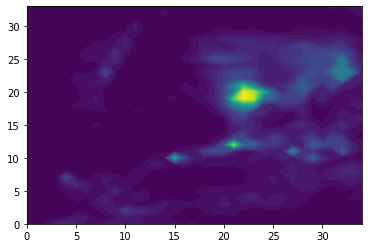

In [1908]:
plt.contourf(era.isel(time=101), 40)

In [1940]:
initial_date

datetime.datetime(2016, 8, 1, 0, 0)

In [1964]:
initial_data = numpy.hstack([downscale(upscale(obs_data.sel(time=initial_date + datetime.timedelta(days=i))).values).values[mask] for i in range(-30 + 1, 1)])

AttributeError: 'numpy.ndarray' object has no attribute 'values'

In [1947]:
initial_pc

array([[ 0.53021353, -1.6325315 ]], dtype=float32)

In [1948]:
initial_pc_true

array([-0.46811927, -1.79857326])

In [1949]:
date_days

92

In [1950]:
pcs2.shape

(116, 153, 2)

In [1951]:
pcs_fcst

array([-0.62609245, -1.51614869])

In [1952]:
true_pc

array([-1.64885705, -0.97931901])

In [1958]:
pcs_model.std(axis=0)

array([0.40733847, 0.58443218])

In [1980]:
data_ens = [(downscale(model_data.sel(initial_time=initial_date, ensemble=ens).isel(forecast_time=i)) + 6 - clim_mean['p'].isel(dayofyear=61+date_days+i).values)[mask] for i in range(day_i + lead_time, day_i + lead_time + regress_days)]
#pcs_model[ens, :] = numpy.array(get_pcs_future(numpy.hstack(data_ens).reshape(1, -1)))

In [1981]:
range(day_i + lead_time, day_i + lead_time + regress_days)

range(5, 34)

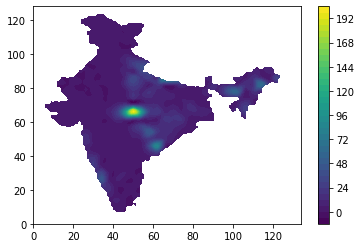

In [1987]:
plt.contourf(downscale(model_data.sel(initial_time=initial_date, ensemble=ens).isel(forecast_time=i)) + 6, 40)
plt.colorbar()

In [1983]:
i

24

In [1992]:
clim_mean['p'].isel(dayofyear=61+date_days+i).sum()

<xarray.DataArray 'p' ()>
array(37854.344, dtype=float32)
Coordinates:
    dayofyear  <U5 '08-25'

In [1994]:
numpy.nansum(downscale(model_data.sel(initial_time=initial_date, ensemble=ens).isel(forecast_time=i)) + 6)

42253.34634121836

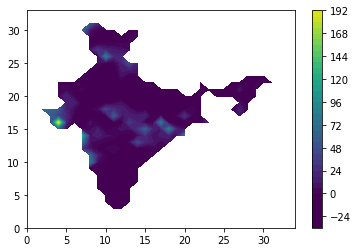

In [2013]:
plt.contourf(upscale(obs_state), 40, vmax=200, vmin=0)
plt.colorbar()

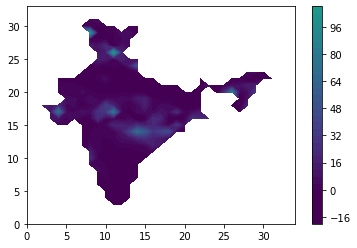

In [2011]:
plt.contourf(obs_state_era, 40, vmax=200, vmin=0)
plt.colorbar()

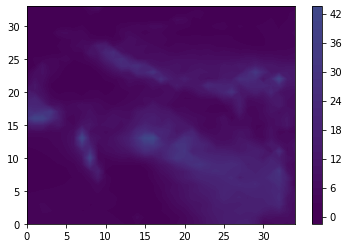

In [2015]:
plt.contourf(numpy.flipud(enoc_pred), 40, vmax=200, vmin=0)
plt.colorbar()

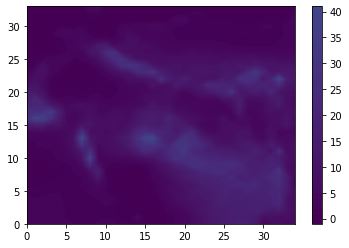

In [2016]:
plt.contourf(numpy.flipud(mean_pred), 40, vmax=200, vmin=0)
plt.colorbar()

In [2055]:
numpy.sqrt(numpy.mean((model_dat_cp - (era + 6))**2))

<xarray.DataArray ()>
array(14.038919, dtype=float32)
Coordinates:
    forecast_time  timedelta64[ns] 1 days

In [2033]:
numpy.sqrt(196.482)

14.01720371543483

In [2034]:
model_data

<xarray.DataArray 'prec' (ensemble: 25, initial_time: 120, forecast_time: 150, lat: 34, lon: 35)>
array([[[[[-6.      , ..., -6.      ],
          ...,
          [-6.      , ..., -2.189117]],

         ...,

         [[-6.      , ...,  0.591797],
          ...,
          [-4.413086, ...,  2.178711]]],


        ...,


        [[[-6.      , ..., -6.      ],
          ...,
          [-3.562408, ..., 15.747589]],

         ...,

         [[-6.      , ..., -5.511719],
          ...,
          [-3.192383, ..., -5.572754]]]],



       ...,



       [[[[-2.986389, ..., -6.      ],
          ...,
          [-5.839783, ..., -5.092102]],

         ...,

         [[-6.      , ..., -6.      ],
          ...,
          [ 3.765625, ..., -4.291016]]],


        ...,


        [[[-6.      , ..., -6.      ],
          ...,
          [-1.246887, ...,  8.518738]],

         ...,

         [[-6.      , ..., -5.755859],
          ...,
          [-5.511719, ..., -5.389648]]]]], dtype=float32)
Coordinates:
  * lat            (lat) float32 39.0 38.0 37.0 36.0 35.0 ... 9.0 8.0 7.0 6.0
  * forecast_time  (forecast_time) timedelta64[ns] 1 days 2 days ... 150 days
  * ensemble       (ensemble) int32 0 1 2 3 4 5 6 7 ... 17 18 19 20 21 22 23 24
  * lon            (lon) float32 66.0 67.0 68.0 69.0 ... 97.0 98.0 99.0 100.0
  * initial_time   (initial_time) datetime64[ns] 1993-05-01 ... 2016-09-01

In [2066]:
model_dat_cp = (model_data + 6).isel(forecast_time=0).mean('ensemble').rename({'initial_time': 'time', 'lon': 'longitude', 'lat': 'latitude'})

In [2052]:
model_dat_cp['time'] = model_dat_cp.time.values + numpy.timedelta64(1, 'D')

In [2053]:
model_dat_cp

<xarray.DataArray 'prec' (time: 120, lat: 34, lon: 35)>
array([[[1.10076904e+00, 5.71411133e+00, 4.97848511e+00, ...,
         0.00000000e+00, 1.09863281e-02, 0.00000000e+00],
        [1.32492065e+00, 3.33145142e+00, 1.05268860e+01, ...,
         3.05175781e-03, 5.03540039e-03, 3.41796875e-01],
        [1.81015015e+00, 8.71017456e+00, 5.27694702e+00, ...,
         3.50952148e-03, 1.80053711e-02, 5.26428223e-01],
        ...,
        [1.43432617e-02, 5.49316406e-03, 7.62939453e-03, ...,
         2.97241211e-01, 9.45892334e-01, 1.57882690e+00],
        [2.21252441e-02, 2.30407715e-02, 2.44140625e-03, ...,
         2.96020508e-01, 6.59484863e-01, 2.95608521e+00],
        [1.48162842e-01, 9.38415527e-02, 7.75146484e-02, ...,
         8.11157227e-01, 1.50726318e+00, 2.16735840e+00]],

       [[0.00000000e+00, 6.94274902e-02, 7.00378418e-01, ...,
         3.28186035e+00, 1.18469238e+00, 0.00000000e+00],
        [3.66210938e-03, 0.00000000e+00, 0.00000000e+00, ...,
         1.45843506e+00, 1.02050781e+00, 3.63006592e-01],
        [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
         1.18759155e+00, 4.65087891e-01, 2.94189453e-01],
...
        [7.40356445e-01, 5.29327393e-01, 5.13305664e-01, ...,
         8.89358521e+00, 7.72796631e+00, 2.55813599e+00],
        [1.12442017e+00, 9.80682373e-01, 8.26263428e-01, ...,
         9.56420898e-01, 3.08990479e+00, 2.68402100e+00],
        [5.63507080e-01, 3.58276367e-01, 1.81579590e-01, ...,
         1.61590576e-01, 6.41937256e-01, 2.69744873e+00]],

       [[0.00000000e+00, 2.40966797e+00, 8.13613892e+00, ...,
         6.36627197e+00, 5.27679443e+00, 3.06701660e-01],
        [5.34057617e-03, 3.22418213e-01, 9.15527344e-03, ...,
         1.41746521e+01, 1.29690552e+01, 9.99130249e+00],
        [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
         7.69195557e-01, 6.45675659e+00, 7.63504028e+00],
        ...,
        [9.46502686e-01, 8.32061768e-01, 1.11785889e+00, ...,
         2.58392334e+00, 2.13363647e+00, 4.91271973e+00],
        [1.18804932e+00, 1.65115356e+00, 2.25784302e+00, ...,
         4.10980225e+00, 5.97091675e+00, 1.01280212e+01],
        [2.90161133e+00, 3.49166870e+00, 4.00787354e+00, ...,
         8.43444824e+00, 1.87501526e+01, 2.03720093e+01]]], dtype=float32)
Coordinates:
  * lat            (lat) float32 39.0 38.0 37.0 36.0 35.0 ... 9.0 8.0 7.0 6.0
    forecast_time  timedelta64[ns] 1 days
  * lon            (lon) float32 66.0 67.0 68.0 69.0 ... 97.0 98.0 99.0 100.0
  * time           (time) datetime64[ns] 1993-05-02 1993-06-02 ... 2016-09-02

In [2061]:
numpy.corrcoef(numpy.ravel(model_dat_cp), numpy.ravel((era + 6)))

ValueError: all the input array dimensions for the concatenation axis must match exactly, but along dimension 1, the array at index 0 has size 142800 and the array at index 1 has size 4369680

In [2207]:
numpy.sqrt(((model_dat_cp - (era + 6))**2).mean())

<xarray.DataArray ()>
array(15.028399, dtype=float32)
Coordinates:
    forecast_time  timedelta64[ns] 1 days

In [2078]:

etkf_pred.mean(axis=1)

(4964,)

In [2081]:
ens_members = [(numpy.flipud(model_data.sel(initial_time=initial_date, ensemble=ens).isel(forecast_time=lead_time)) + 6 - upscale(clim_mean['p'].isel(dayofyear=61+date_days+lead_time).values))[mask_lowres] for ens in range(n_ens)]

In [2082]:
ens_members

[array([-1.11012688e+01, -1.94272563e-01, -1.69728031e+01, -1.41002007e+01,
        -2.84907079e+00, -1.01991498e+00, -2.20645027e+01, -1.19970334e+00,
        -2.23031831e+00, -1.70557415e+00, -2.31847858e+01, -1.32359848e+01,
        -3.30159664e+00, -2.39355254e+00, -3.49545813e+00, -3.04146271e+01,
        -3.55542421e+00, -3.35179234e+00, -3.64134955e+00, -3.25942063e+00,
        -4.08241701e+00, -9.57192612e+00, -2.72891784e+00, -1.85038805e+00,
        -1.79657114e+00, -1.76538134e+00, -3.54282165e+00, -8.66561890e+00,
        -3.92647552e+00, -2.27699924e+00, -3.11455846e+00, -1.93243802e+00,
        -2.24499416e+00, -1.36544907e+00, -5.22272491e+00, -1.70963335e+00,
        -1.66294837e+00, -2.27436090e+00, -3.02074695e+00, -1.74051046e+00,
        -2.97540092e+00, -3.39186215e+00,  4.94650507e+00, -1.78000093e-01,
        -1.08506620e+00, -2.00151849e+00, -3.57033825e+00, -3.65221381e+00,
        -4.24842262e+00, -5.75148916e+00, -4.75668049e+00,  1.35254593e+01,
         1.9

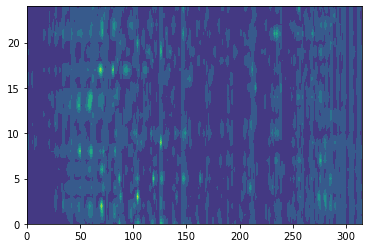

In [2083]:
plt.contourf(ens_members)

In [2085]:
numpy.array(ens_members)

(25, 316)

In [2092]:
a = numpy.nan*numpy.zeros(lowres_lats.shape)
a[mask_lowres] = numpy.array(ens_members).mean(axis=0)

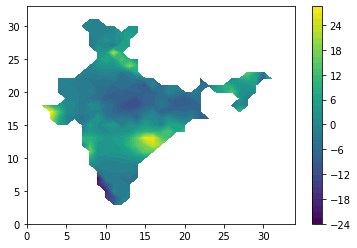

In [2095]:
plt.contourf(a, 40)
plt.colorbar()

In [2097]:
etkf_pred.shape

(4964, 25)

In [2224]:
stds = obs_data.groupby('dayofyear').std(dim=["time", "lat", "lon"])

In [2228]:
stds[stds.dayofyear == '07-15']

<xarray.DataArray 'p' (dayofyear: 1)>
array([16.216734], dtype=float32)
Coordinates:
  * dayofyear  (dayofyear) object '07-15'

In [2230]:
numpy.mean(errs_uncorr)

14.861469

In [119]:
era

<xarray.DataArray 'tp' (time: 3672, lat: 34, lon: 35)>
array([[[3.24742794e-01, 3.42226028e-02, 9.93919373e-03, ...,
         3.71517658e-01, 5.40094376e-02, 7.46581554e-01],
        [4.48226929e-05, 4.48226929e-05, 4.48226929e-05, ...,
         1.84392929e-03, 2.70271301e-02, 1.97973299e+00],
        [9.44137573e-04, 4.48226929e-05, 4.48226929e-05, ...,
         4.48226929e-05, 7.64932632e-02, 1.66312408e+00],
        ...,
        [1.10676289e-01, 1.52951241e-01, 8.17643642e-01, ...,
         9.44137573e-04, 6.12010956e-02, 2.59978771e-01],
        [5.44071198e-03, 2.87738442e+00, 1.56544209e-01, ...,
         1.84392929e-03, 4.48226929e-05, 2.75056243e+00],
        [4.54092026e-03, 4.99919033e+00, 7.68162251e-01, ...,
         6.92618847e-01, 2.18121147e+00, 2.74372101e-03]],

       [[9.44137573e-04, 4.48226929e-05, 4.48226929e-05, ...,
         4.48226929e-05, 9.03749466e-03, 6.83965683e-02],
        [4.48226929e-05, 4.48226929e-05, 4.48226929e-05, ...,
         4.48226929e-05, 3.07652950e-01, 2.13353157e+00],
        [1.84392929e-03, 4.48226929e-05, 4.48226929e-05, ...,
         4.48226929e-05, 2.56527209e+00, 1.43736029e+00],
...
        [4.48226929e-05, 4.48226929e-05, 4.48226929e-05, ...,
         3.24230194e-02, 5.49068451e-02, 5.22624969e-01],
        [1.35861397e-01, 4.48226929e-05, 4.48226929e-05, ...,
         3.21147919e-01, 4.48226929e-05, 6.34050369e-03],
        [4.19188499e-01, 6.74631596e-01, 2.49601889e+00, ...,
         1.47551537e-01, 1.70039177e-01, 4.48226929e-05]],

       [[4.23173904e-02, 8.37426662e-01, 1.29165125e+00, ...,
         3.71511936e-01, 8.68906975e-01, 1.13694572e+00],
        [9.49857712e-01, 1.69459724e+00, 2.35659814e+00, ...,
         3.40932846e-01, 9.24667358e-01, 1.09916735e+00],
        [2.90616608e+00, 2.47802210e+00, 2.46453285e+00, ...,
         1.64153433e+00, 2.62013459e+00, 1.30694199e+00],
        ...,
        [5.44071198e-03, 4.48226929e-05, 4.48226929e-05, ...,
         2.18607426e-01, 5.07330418e-01, 5.64891815e-01],
        [7.24029541e-03, 2.97260284e-02, 1.64642811e-01, ...,
         2.19829941e+00, 7.30395317e-01, 1.01677895e-01],
        [2.79264450e-02, 3.42734337e-01, 5.42733097e+00, ...,
         5.63096046e-01, 2.05438399e+00, 3.64160538e-03]]], dtype=float32)
Coordinates:
  * lat      (lat) float64 6.0 7.0 8.0 9.0 10.0 ... 35.0 36.0 37.0 38.0 39.0
  * time     (time) datetime64[ns] 1993-05-01 1993-05-02 ... 2016-09-30
  * lon      (lon) float32 66.0 67.0 68.0 69.0 70.0 ... 97.0 98.0 99.0 100.0

In [450]:
model_clim = model_data.sel(initial_time=model_data.initial_time.dt.year <= 2007).assign_coords(dayofyear=model_data.initial_time.dt.strftime("%m-%d")).groupby('dayofyear').mean().mean('ensemble')

In [464]:
model_clim

<xarray.DataArray 'prec' (dayofyear: 5, forecast_time: 150, lat: 34, lon: 35)>
array([[[[2.19987488e+00, 1.90551221e+00, 2.36239648e+00, ...,
          6.15326405e+00, 7.62361717e+00, 7.82522583e+00],
         [1.36581945e+00, 1.34224963e+00, 1.73539746e+00, ...,
          5.61926842e+00, 6.80179882e+00, 6.77993298e+00],
         [9.26925659e-01, 1.05604541e+00, 1.58331800e+00, ...,
          6.57326889e+00, 6.36577272e+00, 4.36251879e+00],
         ...,
         [1.37017322e+00, 1.44647217e+00, 1.18506372e+00, ...,
          3.29798400e-01, 5.04053831e-01, 9.16117489e-01],
         [1.93915296e+00, 2.84149647e+00, 3.34460974e+00, ...,
          1.14401257e+00, 1.70202100e+00, 2.72588634e+00],
         [1.38263941e+00, 4.38579845e+00, 6.60219908e+00, ...,
          1.56348181e+00, 1.73457861e+00, 9.79207397e-01]],

        [[2.41004944e+00, 2.54824305e+00, 2.88610864e+00, ...,
          5.91713905e+00, 8.40469360e+00, 7.53430176e+00],
         [1.88631701e+00, 2.03175378e+00, 2.24751306e+00, ...,
          5.65740490e+00, 7.90016747e+00, 6.95657825e+00],
         [1.35365295e+00, 1.51712573e+00, 1.82251477e+00, ...,
          7.28290272e+00, 7.40953541e+00, 5.38498878e+00],
...
          2.24934906e-01, 1.55436203e-01, 1.23697922e-01],
         [9.70540404e-01, 1.42187500e+00, 1.56201184e+00, ...,
          2.56510437e-01, 2.53580719e-01, 3.38704467e-01],
         [1.01253271e+00, 1.86995459e+00, 2.66943383e+00, ...,
          2.86132783e-01, 3.28125000e-01, 2.42187485e-01]],

        [[3.65445948e+00, 3.04817724e+00, 2.73909545e+00, ...,
          5.30582714e+00, 3.62321043e+00, 2.33300781e+00],
         [2.98616552e+00, 2.57779932e+00, 2.53759789e+00, ...,
          2.94384766e+00, 1.59309888e+00, 2.74137402e+00],
         [2.33317065e+00, 2.06624341e+00, 2.00211620e+00, ...,
          1.63818359e+00, 1.76595032e+00, 3.63183618e+00],
         ...,
         [8.89485598e-01, 9.41731632e-01, 1.01676440e+00, ...,
          2.26399764e-01, 1.55598968e-01, 1.21907562e-01],
         [9.54752564e-01, 1.48746753e+00, 1.43522143e+00, ...,
          2.32421890e-01, 2.25097641e-01, 2.78320312e-01],
         [1.03027332e+00, 1.91943359e+00, 2.63688183e+00, ...,
          2.57324219e-01, 3.13639313e-01, 2.35026032e-01]]]],
      dtype=float32)
Coordinates:
  * lat            (lat) float64 6.0 7.0 8.0 9.0 10.0 ... 36.0 37.0 38.0 39.0
  * forecast_time  (forecast_time) timedelta64[ns] 1 days 2 days ... 150 days
  * lon            (lon) float32 66.0 67.0 68.0 69.0 ... 97.0 98.0 99.0 100.0
  * dayofyear      (dayofyear) object '05-01' '06-01' '07-01' '08-01' '09-01'

In [473]:
model_clim.to_netcdf('seas5_clim.nc')

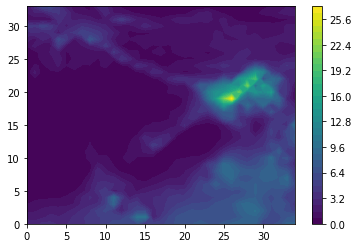

In [979]:
plt.contourf(model_clim.isel(dayofyear=0, forecast_time=0), 40)
plt.colorbar()

In [977]:
model_clim

<xarray.DataArray 'prec' (dayofyear: 5, forecast_time: 150, lat: 34, lon: 35)>
array([[[[ 2.74880099e+00,  2.57220268e+00,  3.46816373e+00, ...,
           6.54204941e+00,  8.32007790e+00,  8.09509850e+00],
         [ 2.18493176e+00,  2.19738030e+00,  2.23380733e+00, ...,
           6.06863642e+00,  7.05341053e+00,  7.44498539e+00],
         [ 1.27700484e+00,  1.45643556e+00,  1.83558452e+00, ...,
           6.67170763e+00,  6.15506697e+00,  5.03466892e+00],
         ...,
         [ 1.17068303e+00,  1.07896173e+00,  8.75736952e-01, ...,
           5.87072372e-01,  6.84321642e-01,  8.31591249e-01],
         [ 1.50123930e+00,  2.28573155e+00,  2.21524882e+00, ...,
           1.60798383e+00,  1.95199645e+00,  2.25485802e+00],
         [ 1.33246756e+00,  3.56492043e+00,  5.74944496e+00, ...,
           1.37762713e+00,  1.57671916e+00,  7.72393465e-01]],

        [[ 2.43127203e+00,  2.48734474e+00,  2.65743256e+00, ...,
           6.02423573e+00,  8.56669712e+00,  7.96634722e+00],
         [ 1.75474155e+00,  1.84970856e+00,  2.05842018e+00, ...,
           6.69170332e+00,  8.56828403e+00,  7.28363037e+00],
         [ 1.23884535e+00,  1.33582735e+00,  1.64671266e+00, ...,
           8.09590530e+00,  7.24010134e+00,  5.59743834e+00],
...
           2.24507660e-01,  1.67439789e-01,  1.26037613e-01],
         [ 1.01765943e+00,  1.43829346e+00,  1.58945727e+00, ...,
           2.65808076e-01,  2.50142455e-01,  3.36812377e-01],
         [ 1.04502368e+00,  1.86360657e+00,  2.67079639e+00, ...,
           2.93172210e-01,  3.42000306e-01,  2.58585632e-01]],

        [[ 3.45611596e+00,  3.06213379e+00,  2.65604639e+00, ...,
           4.99979687e+00,  3.55082154e+00,  2.24700904e+00],
         [ 2.84525537e+00,  2.50762916e+00,  2.43164086e+00, ...,
           2.84739161e+00,  1.54510510e+00,  2.60396290e+00],
         [ 2.34629321e+00,  2.03257227e+00,  1.87266040e+00, ...,
           1.65863037e+00,  1.70674634e+00,  3.42753124e+00],
         ...,
         [ 8.31909239e-01,  8.51542294e-01,  9.52453613e-01, ...,
           2.24304184e-01,  1.56962067e-01,  1.29394531e-01],
         [ 9.56319094e-01,  1.48661280e+00,  1.42598462e+00, ...,
           2.40885451e-01,  2.31221482e-01,  2.81270385e-01],
         [ 1.09110510e+00,  1.84773779e+00,  2.56683350e+00, ...,
           2.71606475e-01,  3.14432800e-01,  2.13724792e-01]]]],
      dtype=float32)
Coordinates:
  * lat            (lat) float64 6.0 7.0 8.0 9.0 10.0 ... 36.0 37.0 38.0 39.0
  * forecast_time  (forecast_time) timedelta64[ns] 1 days 2 days ... 150 days
  * lon            (lon) float32 66.0 67.0 68.0 69.0 ... 97.0 98.0 99.0 100.0
  * dayofyear      (dayofyear) object '05-01' '06-01' '07-01' '08-01' '09-01'

In [1056]:
era

<xarray.DataArray 'tp' (time: 3672, lat: 34, lon: 35)>
array([[[3.24742794e-01, 3.42226028e-02, 9.93919373e-03, ...,
         3.71517658e-01, 5.40094376e-02, 7.46581554e-01],
        [4.48226929e-05, 4.48226929e-05, 4.48226929e-05, ...,
         1.84392929e-03, 2.70271301e-02, 1.97973299e+00],
        [9.44137573e-04, 4.48226929e-05, 4.48226929e-05, ...,
         4.48226929e-05, 7.64932632e-02, 1.66312408e+00],
        ...,
        [1.10676289e-01, 1.52951241e-01, 8.17643642e-01, ...,
         9.44137573e-04, 6.12010956e-02, 2.59978771e-01],
        [5.44071198e-03, 2.87738442e+00, 1.56544209e-01, ...,
         1.84392929e-03, 4.48226929e-05, 2.75056243e+00],
        [4.54092026e-03, 4.99919033e+00, 7.68162251e-01, ...,
         6.92618847e-01, 2.18121147e+00, 2.74372101e-03]],

       [[9.44137573e-04, 4.48226929e-05, 4.48226929e-05, ...,
         4.48226929e-05, 9.03749466e-03, 6.83965683e-02],
        [4.48226929e-05, 4.48226929e-05, 4.48226929e-05, ...,
         4.48226929e-05, 3.07652950e-01, 2.13353157e+00],
        [1.84392929e-03, 4.48226929e-05, 4.48226929e-05, ...,
         4.48226929e-05, 2.56527209e+00, 1.43736029e+00],
...
        [4.48226929e-05, 4.48226929e-05, 4.48226929e-05, ...,
         3.24230194e-02, 5.49068451e-02, 5.22624969e-01],
        [1.35861397e-01, 4.48226929e-05, 4.48226929e-05, ...,
         3.21147919e-01, 4.48226929e-05, 6.34050369e-03],
        [4.19188499e-01, 6.74631596e-01, 2.49601889e+00, ...,
         1.47551537e-01, 1.70039177e-01, 4.48226929e-05]],

       [[4.23173904e-02, 8.37426662e-01, 1.29165125e+00, ...,
         3.71511936e-01, 8.68906975e-01, 1.13694572e+00],
        [9.49857712e-01, 1.69459724e+00, 2.35659814e+00, ...,
         3.40932846e-01, 9.24667358e-01, 1.09916735e+00],
        [2.90616608e+00, 2.47802210e+00, 2.46453285e+00, ...,
         1.64153433e+00, 2.62013459e+00, 1.30694199e+00],
        ...,
        [5.44071198e-03, 4.48226929e-05, 4.48226929e-05, ...,
         2.18607426e-01, 5.07330418e-01, 5.64891815e-01],
        [7.24029541e-03, 2.97260284e-02, 1.64642811e-01, ...,
         2.19829941e+00, 7.30395317e-01, 1.01677895e-01],
        [2.79264450e-02, 3.42734337e-01, 5.42733097e+00, ...,
         5.63096046e-01, 2.05438399e+00, 3.64160538e-03]]], dtype=float32)
Coordinates:
  * lat      (lat) float64 6.0 7.0 8.0 9.0 10.0 ... 35.0 36.0 37.0 38.0 39.0
  * time     (time) datetime64[ns] 1993-05-01 1993-05-02 ... 2016-09-30
  * lon      (lon) float32 66.0 67.0 68.0 69.0 70.0 ... 97.0 98.0 99.0 100.0

In [1070]:
forecasts = xarray.open_dataset('seas5_forecasts_processed.nc')['p']

In [1071]:
forecasts

<xarray.DataArray 'p' (ensemble: 51, initial_time: 25, forecast_time: 44, lat: 34, lon: 35)>
[66759000 values with dtype=float32]
Coordinates:
  * lat            (lat) float32 6.0 7.0 8.0 9.0 10.0 ... 36.0 37.0 38.0 39.0
  * initial_time   (initial_time) datetime64[ns] 2017-05-01 ... 2021-09-01
  * lon            (lon) float32 66.0 67.0 68.0 69.0 ... 97.0 98.0 99.0 100.0
  * forecast_time  (forecast_time) timedelta64[ns] 1 days 2 days ... 44 days
  * ensemble       (ensemble) int32 0 1 2 3 4 5 6 7 ... 43 44 45 46 47 48 49 50

In [1072]:
model_data

<xarray.DataArray 'prec' (ensemble: 25, initial_time: 120, forecast_time: 150, lat: 34, lon: 35)>
array([[[[[ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00, ...,
            1.11770630e+00,  1.69372559e+00,  3.81088257e+00],
          [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00, ...,
            2.21252441e-01,  6.40869141e-01,  8.22830200e+00],
          [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00, ...,
            1.56402588e-01,  1.46865845e+00,  2.55966187e+00],
          ...,
          [ 1.85775757e+00,  8.37326050e+00,  2.14004517e+00, ...,
            0.00000000e+00,  0.00000000e+00,  5.68389893e-01],
          [ 9.95635986e-01,  2.77328491e+00,  2.55966187e+00, ...,
            0.00000000e+00,  0.00000000e+00,  5.79833984e-01],
          [ 0.00000000e+00,  6.52694702e+00,  4.76074219e+00, ...,
            0.00000000e+00,  0.00000000e+00,  0.00000000e+00]],

         [[ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00, ...,
            2.82287598e-01,  3.49807739e+00,  1.02233887e+00],
          [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00, ...,
            6.29425049e-01,  1.61743164e+00,  2.36129761e+00],
          [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00, ...,
            1.60980225e+00,  1.37329102e+00,  6.29425049e-01],
...
            3.66210938e-01,  4.88281250e-01,  3.66210938e-01],
          [ 0.00000000e+00,  0.00000000e+00,  1.22070312e-01, ...,
            2.44140625e-01,  2.44140625e-01,  4.88281250e-01],
          [ 1.22070312e-01,  3.66210938e-01,  2.80761719e+00, ...,
            1.22070312e-01,  0.00000000e+00,  0.00000000e+00]],

         [[ 4.88281250e-01,  4.88281250e-01,  0.00000000e+00, ...,
            1.20849609e+01,  2.68554688e+00,  6.10351562e-01],
          [ 6.10351562e-01,  7.32421875e-01,  8.54492188e-01, ...,
            1.58691406e+00,  6.10351562e-01,  1.83105469e+00],
          [ 1.95312500e+00,  1.09863281e+00,  6.10351562e-01, ...,
            8.54492188e-01,  6.10351562e-01,  5.85937500e+00],
          ...,
          [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00, ...,
            0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
          [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00, ...,
            2.44140625e-01,  4.88281250e-01,  3.66210938e-01],
          [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00, ...,
            2.44140625e-01,  2.44140625e-01,  2.44140625e-01]]]]],
      dtype=float32)
Coordinates:
  * lat            (lat) float64 6.0 7.0 8.0 9.0 10.0 ... 36.0 37.0 38.0 39.0
  * forecast_time  (forecast_time) timedelta64[ns] 1 days 2 days ... 150 days
  * ensemble       (ensemble) int32 0 1 2 3 4 5 6 7 ... 17 18 19 20 21 22 23 24
  * lon            (lon) float32 66.0 67.0 68.0 69.0 ... 97.0 98.0 99.0 100.0
  * initial_time   (initial_time) datetime64[ns] 1993-05-01 ... 2016-09-01

In [435]:
df1 = xarray.open_dataset('era5_prec_1950_1966.nc')
df2 = xarray.open_dataset('era5_prec_1967_1979.nc')
df3 = xarray.open_dataset('era5_prec_1980_1995.nc')
df4 = xarray.open_dataset('era5_prec_1996_2012.nc')
df5 = xarray.open_dataset('era5_prec_2013_2021.nc')

In [436]:
df5 = df5.sel(expver=1).dropna('time').drop_vars('expver')

In [437]:
combined = xarray.concat([df1, df2, df3, df4, df5], 'time').rename({'latitude': 'lat', 'longitude': 'lon'})

In [438]:
combined = combined.resample(time='D').sum()

In [439]:
combined = combined.reindex(lat=combined.lat[::-1])

In [440]:
combined = combined*1000

In [441]:
combined = combined['tp'].loc[(combined.time.dt.month >= 3) & (combined.time.dt.month <= 11)]

In [442]:
combined.to_netcdf('era5_prec_combined.nc')

PermissionError: [Errno 13] Permission denied: b'/lustre/ebach/SSA/prec_new/era5_prec_combined.nc'

In [443]:
clim_verify = combined.loc[(combined.time.dt.year >= 1993) & (combined.time.dt.year <= 2007)].assign_coords(dayofyear=combined.time.dt.strftime("%m-%d")).groupby('dayofyear').mean()

In [444]:
era_anomalies = combined.assign_coords(dayofyear=combined.time.dt.strftime("%m-%d")).groupby('dayofyear') - clim_verify

In [446]:
era_anomalies.to_netcdf('era5_anomalies.nc')

In [474]:
clim_verify.to_netcdf('era5_clim.nc')

In [176]:
stacked = era_anomalies.stack(stacked=['lat', 'lon'])

In [175]:
stacked.shape

(275, 1190, 60)

In [174]:
stacked = xarray.DataArray(stacked.loc[stacked.time.dt.year < 2010].values.reshape(60, -1, 1190).transpose([1, 2, 0])).rename('prec')

In [179]:
stacked_new = xarray.DataArray(stacked.loc[(stacked.time.dt.year >= 2010) & (stacked.time.dt.year < 2021)].values.reshape(11, -1, 1190).transpose([1, 2, 0])).rename('prec')

In [180]:
stacked_new

<xarray.DataArray 'prec' (dim_0: 275, dim_1: 1190, dim_2: 11)>
array([[[-1.35614812e+00, -1.18525410e+00, -1.64846230e+00, ...,
         -3.04085135e-01, -1.64704299e+00, -1.62812221e+00],
        [-1.87048149e+00, -1.49091542e+00, -2.04137182e+00, ...,
         -6.18787766e-01, -2.05164242e+00, -1.93966758e+00],
        [-2.03731680e+00, -1.87091732e+00, -2.12096262e+00, ...,
         -5.17611504e-02, -2.12100720e+00, -2.07606339e+00],
        ...,
        [ 1.75439835e-01, -4.07398582e-01,  1.35860503e-01, ...,
         -1.25582218e-01,  2.72653162e-01,  4.72168505e-01],
        [ 8.20706487e-02, -5.93410134e-01, -3.94639850e-01, ...,
         -4.26910162e-01, -2.67618626e-01,  9.21570420e-01],
        [ 1.29969573e+00, -7.55546868e-01, -7.16872752e-01, ...,
         -6.32575035e-01, -7.45345175e-01, -7.05914855e-01]],

       [[-1.28169560e+00, -1.31857216e+00, -1.37793279e+00, ...,
         -8.77441943e-01, -1.30879331e+00, -1.37661040e+00],
        [-1.11666691e+00, -1.08787966e+00, -1.20210457e+00, ...,
         -7.62088180e-01, -1.20921421e+00, -1.19265723e+00],
        [-4.41802382e-01, -1.21712840e+00, -1.30617023e+00, ...,
         -1.18904161e+00, -1.30732703e+00, -1.19377089e+00],
...
         -9.31877941e-02,  6.65430307e-01,  3.66546571e-01],
        [-1.10201299e-01, -1.20993465e-01, -1.18294492e-01, ...,
         -1.07634574e-01,  1.80468547e+00,  2.31450647e-01],
        [-4.36230339e-02, -4.36230339e-02, -4.36230339e-02, ...,
         -4.36677374e-02,  7.75665164e-01,  8.32864344e-02]],

       [[-6.05462790e+00, -8.52722168e+00, -9.54089260e+00, ...,
         -6.53331470e+00, -6.64609051e+00, -8.22484016e+00],
        [-4.92514515e+00, -7.51466560e+00, -8.67764854e+00, ...,
         -2.40928555e+00, -6.96812439e+00, -7.86238384e+00],
        [-6.93688393e-01, -9.77995491e+00, -1.05552731e+01, ...,
          4.18435764e+00, -6.93160343e+00, -1.03107080e+01],
        ...,
        [-1.34527922e-01,  1.73073024e-01,  1.02026150e-01, ...,
         -1.08218059e-01,  1.59904122e-01, -4.74976897e-02],
        [-2.54848629e-01,  2.07467347e-01,  1.79577947e-01, ...,
         -2.20426947e-01,  2.08768845e-02, -2.14121893e-01],
        [-2.04256982e-01, -3.68176401e-03, -8.28348696e-02, ...,
         -2.04301685e-01,  2.76726425e-01, -6.55197203e-02]]],
      dtype=float32)
Dimensions without coordinates: dim_0, dim_1, dim_2

In [1257]:
stacked.to_netcdf('prec_out_era5.nc')

In [181]:
stacked_new.to_netcdf('prec_out_era5_new.nc')

In [182]:
stacked_new

<xarray.DataArray 'prec' (dim_0: 275, dim_1: 1190, dim_2: 11)>
array([[[-1.35614812e+00, -1.18525410e+00, -1.64846230e+00, ...,
         -3.04085135e-01, -1.64704299e+00, -1.62812221e+00],
        [-1.87048149e+00, -1.49091542e+00, -2.04137182e+00, ...,
         -6.18787766e-01, -2.05164242e+00, -1.93966758e+00],
        [-2.03731680e+00, -1.87091732e+00, -2.12096262e+00, ...,
         -5.17611504e-02, -2.12100720e+00, -2.07606339e+00],
        ...,
        [ 1.75439835e-01, -4.07398582e-01,  1.35860503e-01, ...,
         -1.25582218e-01,  2.72653162e-01,  4.72168505e-01],
        [ 8.20706487e-02, -5.93410134e-01, -3.94639850e-01, ...,
         -4.26910162e-01, -2.67618626e-01,  9.21570420e-01],
        [ 1.29969573e+00, -7.55546868e-01, -7.16872752e-01, ...,
         -6.32575035e-01, -7.45345175e-01, -7.05914855e-01]],

       [[-1.28169560e+00, -1.31857216e+00, -1.37793279e+00, ...,
         -8.77441943e-01, -1.30879331e+00, -1.37661040e+00],
        [-1.11666691e+00, -1.08787966e+00, -1.20210457e+00, ...,
         -7.62088180e-01, -1.20921421e+00, -1.19265723e+00],
        [-4.41802382e-01, -1.21712840e+00, -1.30617023e+00, ...,
         -1.18904161e+00, -1.30732703e+00, -1.19377089e+00],
...
         -9.31877941e-02,  6.65430307e-01,  3.66546571e-01],
        [-1.10201299e-01, -1.20993465e-01, -1.18294492e-01, ...,
         -1.07634574e-01,  1.80468547e+00,  2.31450647e-01],
        [-4.36230339e-02, -4.36230339e-02, -4.36230339e-02, ...,
         -4.36677374e-02,  7.75665164e-01,  8.32864344e-02]],

       [[-6.05462790e+00, -8.52722168e+00, -9.54089260e+00, ...,
         -6.53331470e+00, -6.64609051e+00, -8.22484016e+00],
        [-4.92514515e+00, -7.51466560e+00, -8.67764854e+00, ...,
         -2.40928555e+00, -6.96812439e+00, -7.86238384e+00],
        [-6.93688393e-01, -9.77995491e+00, -1.05552731e+01, ...,
          4.18435764e+00, -6.93160343e+00, -1.03107080e+01],
        ...,
        [-1.34527922e-01,  1.73073024e-01,  1.02026150e-01, ...,
         -1.08218059e-01,  1.59904122e-01, -4.74976897e-02],
        [-2.54848629e-01,  2.07467347e-01,  1.79577947e-01, ...,
         -2.20426947e-01,  2.08768845e-02, -2.14121893e-01],
        [-2.04256982e-01, -3.68176401e-03, -8.28348696e-02, ...,
         -2.04301685e-01,  2.76726425e-01, -6.55197203e-02]]],
      dtype=float32)
Dimensions without coordinates: dim_0, dim_1, dim_2

In [1209]:
prec_out = xarray.open_dataset('prec_out.nc')

In [1213]:
prec_out['prec'].values.shape

(153, 4964, 116)

In [1258]:
evecs = xarray.open_dataset('eig_vecs_era5.h5')

In [1285]:
evals = xarray.open_dataset('eig_vals_era5.h5')

In [1297]:
r = xarray.open_dataset('r_summed_era5.h5')

In [1290]:
ev1 = evecs["eig_vecs"].values[0, :]
ev2 = evecs["eig_vecs"].values[1, :]

In [1261]:
61*1190

72590

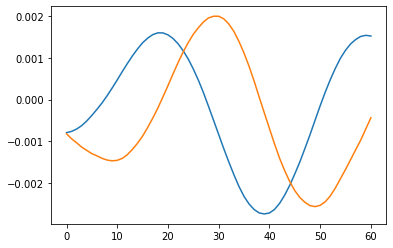

In [1291]:
plt.plot(ev1.reshape(1190, 61)[0, :])
plt.plot(ev2.reshape(1190, 61)[0, :])

In [1296]:
sum(evals['eig_vals'][:2])/sum(evals['eig_vals'])

<xarray.DataArray 'eig_vals' ()>
array(0.02981333)

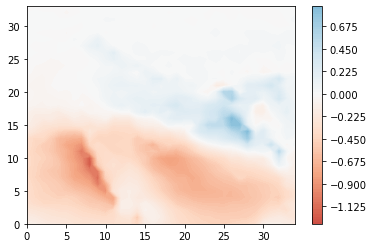

In [1328]:
plt.contourf(r["r_summed"].values[0, :, 60].reshape(34, -1), 100, vmax=2, vmin=-2, cmap='RdBu')
plt.colorbar()

(array([4.000000e+00, 4.000000e+00, 0.000000e+00, 6.000000e+00,
        5.000000e+00, 7.000000e+00, 6.000000e+00, 6.000000e+00,
        9.000000e+00, 1.200000e+01, 1.800000e+01, 3.000000e+01,
        3.300000e+01, 5.100000e+01, 4.600000e+01, 7.600000e+01,
        8.500000e+01, 1.230000e+02, 1.510000e+02, 2.130000e+02,
        2.770000e+02, 3.440000e+02, 4.100000e+02, 5.480000e+02,
        7.170000e+02, 9.690000e+02, 1.138000e+03, 1.558000e+03,
        2.154000e+03, 2.717000e+03, 3.594000e+03, 4.778000e+03,
        6.359000e+03, 8.375000e+03, 1.125000e+04, 1.545100e+04,
        2.101300e+04, 2.916700e+04, 4.093800e+04, 5.930000e+04,
        8.561700e+04, 1.236970e+05, 1.843640e+05, 2.809090e+05,
        4.303790e+05, 6.700640e+05, 1.102602e+06, 2.320205e+06,
        9.365728e+06, 1.995538e+06, 1.029278e+06, 6.140960e+05,
        3.856500e+05, 2.531780e+05, 1.710620e+05, 1.174820e+05,
        8.180600e+04, 5.790500e+04, 4.130700e+04, 2.968200e+04,
        2.094200e+04, 1.561200e+04, 1.14

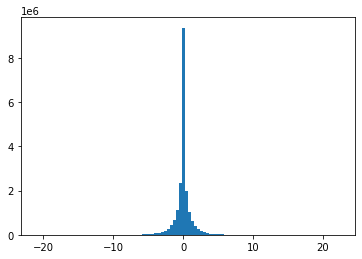

In [1338]:
plt.hist(r["r_summed"].values.ravel(), 100)

In [1339]:
34*35

1190

In [1342]:
pcs_era = xarray.open_dataset('pcs_era5.h5')

In [1347]:
pcs_era = pcs_era["pcs"].values.T

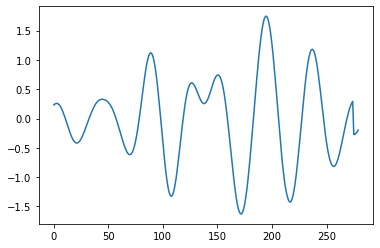

In [1353]:
plt.plot(pcs_era[:280, 0])

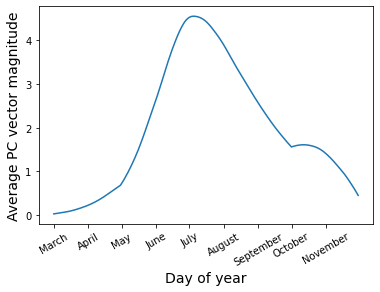

In [1422]:
plt.plot((pcs_era[:, 0]**2 + pcs_era[:, 1]**2).reshape(-1, 275).mean(axis=0))
plt.xticks([0, 31, 61, 92, 122, 153, 184, 214, 245],
           ['March', 'April', 'May', 'June', 'July', 'August', 'September', 'October', 'November'], rotation=30)
plt.xlabel('Day of year', size=14)
plt.ylabel('Average PC vector magnitude', size=14)
plt.savefig("pc_magnitude.pdf")

In [1438]:
datetime.datetime(month=11, year=2010, day=30) - datetime.datetime(month=9, year=2010, day=30)

datetime.timedelta(days=61)

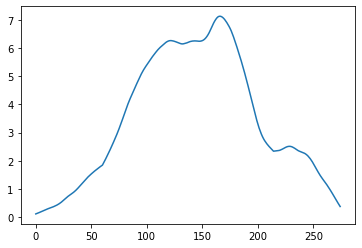

In [1387]:
plt.plot((pcs_era[:, 0]**2 + pcs_era[:, 1]**2).reshape(-1, 275)[-1, :])

In [1388]:
era_anomalies.dayofyear

<xarray.DataArray 'dayofyear' (time: 19710)>
array(['03-01', '03-02', '03-03', ..., '08-30', '08-31', '09-01'],
      dtype=object)
Coordinates:
  * time       (time) datetime64[ns] 1950-03-01 1950-03-02 ... 2021-09-01
    dayofyear  (time) object '03-01' '03-02' '03-03' ... '08-30' '08-31' '09-01'

In [1427]:
23454900/1190/275

71.67272727272727

In [1428]:
era_anomalies

<xarray.DataArray 'tp' (time: 19710, lat: 34, lon: 35)>
array([[[ 1.02244349e+01,  2.28076534e+01,  3.51096606e+00, ...,
          2.52686167e+00,  2.77075982e+00,  5.93473077e-01],
        [ 8.30576515e+00,  1.75382843e+01,  1.62350750e+01, ...,
          1.32442355e+00, -7.17467785e-01,  2.08056855e+00],
        [ 1.69249082e+00,  1.64540787e+01,  1.24253922e+01, ...,
         -1.28715611e+00, -5.68173170e-01,  1.35412741e+00],
        ...,
        [ 1.91721272e+00,  1.05877697e-01, -4.51415777e-02, ...,
          7.59338588e-03, -6.51134551e-03, -9.66720283e-02],
        [ 1.98794806e+00, -4.50192690e-01, -4.09364939e-01, ...,
         -6.88786805e-02, -1.04449958e-01, -4.33462739e-01],
        [ 5.10688066e-01,  1.04920340e+00, -3.14575601e+00, ...,
          5.17191291e-02,  1.58713698e-01, -3.99686426e-01]],

       [[ 4.23697662e+00,  1.56969118e+00,  5.91419697e+00, ...,
          4.91660690e+00,  5.30888510e+00,  6.27793741e+00],
        [ 5.78985119e+00,  1.91929569e+01,  3.96881866e+01, ...,
          5.05568886e+00,  2.72661805e+00,  1.40867062e+01],
        [ 6.53723049e+00,  6.61298599e+01,  1.15390778e+02, ...,
         -4.75618482e-01,  7.11897278e+00,  6.87987518e+00],
...
         -7.49711752e-01, -1.51501215e+00, -3.85050774e+00],
        [-1.07021385e-03, -3.60222533e-02, -2.03394634e-03, ...,
         -1.32907629e+00, -3.15002346e+00, -3.43362427e+00],
        [-1.52214747e-02, -3.41937579e-02,  7.97281384e-01, ...,
         -1.66992152e+00, -3.45943284e+00, -1.34389687e+00]],

       [[-2.09041810e+00, -2.24421930e+00, -2.37568688e+00, ...,
         -4.51487780e+00, -6.78162479e+00, -6.18845749e+00],
        [-1.82688165e+00, -2.13252497e+00, -2.55718303e+00, ...,
         -3.98047590e+00, -6.19275665e+00,  2.13961363e+00],
        [-1.80017829e+00, -2.00804687e+00, -1.86605108e+00, ...,
         -5.66162395e+00, -7.33956146e+00, -3.53957486e+00],
        ...,
        [-7.50857079e-03, -6.50435686e-04, -1.70742467e-04, ...,
         -1.45850968e+00, -3.19885468e+00, -5.74809980e+00],
        [-4.88214828e-02, -1.31650731e-01, -8.26573651e-03, ...,
         -2.70144820e+00, -4.32865572e+00, -4.91923618e+00],
        [-1.23268798e-01, -2.06184283e-01, -1.28108227e+00, ...,
         -2.23417592e+00, -4.37826824e+00, -1.74388063e+00]]],
      dtype=float32)
Coordinates:
  * lat        (lat) float64 6.0 7.0 8.0 9.0 10.0 ... 35.0 36.0 37.0 38.0 39.0
  * time       (time) datetime64[ns] 1950-03-01 1950-03-02 ... 2021-09-01
  * lon        (lon) float32 66.0 67.0 68.0 69.0 70.0 ... 97.0 98.0 99.0 100.0
    dayofyear  (time) object '03-01' '03-02' '03-03' ... '08-30' '08-31' '09-01'

In [167]:
clim_30_year.to_netcdf('clim_30year.nc')

In [111]:
model_data

<xarray.DataArray 'prec' (ensemble: 25, initial_time: 120, forecast_time: 150, lat: 34, lon: 35)>
array([[[[[ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00, ...,
            1.11770630e+00,  1.69372559e+00,  3.81088257e+00],
          [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00, ...,
            2.21252441e-01,  6.40869141e-01,  8.22830200e+00],
          [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00, ...,
            1.56402588e-01,  1.46865845e+00,  2.55966187e+00],
          ...,
          [ 1.85775757e+00,  8.37326050e+00,  2.14004517e+00, ...,
            0.00000000e+00,  0.00000000e+00,  5.68389893e-01],
          [ 9.95635986e-01,  2.77328491e+00,  2.55966187e+00, ...,
            0.00000000e+00,  0.00000000e+00,  5.79833984e-01],
          [ 0.00000000e+00,  6.52694702e+00,  4.76074219e+00, ...,
            0.00000000e+00,  0.00000000e+00,  0.00000000e+00]],

         [[ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00, ...,
            2.82287598e-01,  3.49807739e+00,  1.02233887e+00],
          [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00, ...,
            6.29425049e-01,  1.61743164e+00,  2.36129761e+00],
          [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00, ...,
            1.60980225e+00,  1.37329102e+00,  6.29425049e-01],
...
            3.66210938e-01,  4.88281250e-01,  3.66210938e-01],
          [ 0.00000000e+00,  0.00000000e+00,  1.22070312e-01, ...,
            2.44140625e-01,  2.44140625e-01,  4.88281250e-01],
          [ 1.22070312e-01,  3.66210938e-01,  2.80761719e+00, ...,
            1.22070312e-01,  0.00000000e+00,  0.00000000e+00]],

         [[ 4.88281250e-01,  4.88281250e-01,  0.00000000e+00, ...,
            1.20849609e+01,  2.68554688e+00,  6.10351562e-01],
          [ 6.10351562e-01,  7.32421875e-01,  8.54492188e-01, ...,
            1.58691406e+00,  6.10351562e-01,  1.83105469e+00],
          [ 1.95312500e+00,  1.09863281e+00,  6.10351562e-01, ...,
            8.54492188e-01,  6.10351562e-01,  5.85937500e+00],
          ...,
          [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00, ...,
            0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
          [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00, ...,
            2.44140625e-01,  4.88281250e-01,  3.66210938e-01],
          [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00, ...,
            2.44140625e-01,  2.44140625e-01,  2.44140625e-01]]]]],
      dtype=float32)
Coordinates:
  * lat            (lat) float64 6.0 7.0 8.0 9.0 10.0 ... 36.0 37.0 38.0 39.0
  * forecast_time  (forecast_time) timedelta64[ns] 1 days 2 days ... 150 days
  * ensemble       (ensemble) int32 0 1 2 3 4 5 6 7 ... 17 18 19 20 21 22 23 24
  * lon            (lon) float32 66.0 67.0 68.0 69.0 ... 97.0 98.0 99.0 100.0
  * initial_time   (initial_time) datetime64[ns] 1993-05-01 ... 2016-09-01

In [225]:
pcs = xarray.open_dataset('pcs.h5')['pcs'].values.T

In [235]:
pcs.shape

(31625, 2)

In [215]:
115*275

31625

In [220]:
17748/153

116.0

In [227]:
pcs2 = pcs.reshape(-1, 275, 2)

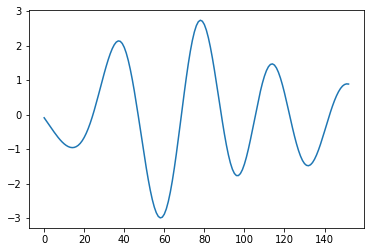

In [234]:
plt.plot(-pcs2[90, 61:-61, 0])

In [244]:
xarray.open_dataset('prec_out.nc')['prec'].values.shape

(275, 4964, 115)

In [237]:
31900/275

116.0

In [457]:
model_anomalies = model_data.assign_coords(dayofyear=model_data.initial_time.dt.strftime("%m-%d")).groupby('dayofyear') - model_clim

In [460]:
model_anomalies.to_netcdf('seas5_anomalies.nc')

In [472]:
model_anomalies

<xarray.DataArray 'prec' (ensemble: 25, initial_time: 120, forecast_time: 150, lat: 34, lon: 35)>
array([[[[[-2.19987488e+00, -1.90551221e+00, -2.36239648e+00, ...,
           -5.03555775e+00, -5.92989159e+00, -4.01434326e+00],
          [-1.36581945e+00, -1.34224963e+00, -1.73539746e+00, ...,
           -5.39801598e+00, -6.16092968e+00,  1.44836903e+00],
          [-9.26925659e-01, -1.05604541e+00, -1.58331800e+00, ...,
           -6.41686630e+00, -4.89711428e+00, -1.80285692e+00],
          ...,
          [ 4.87584352e-01,  6.92678833e+00,  9.54981446e-01, ...,
           -3.29798400e-01, -5.04053831e-01, -3.47727597e-01],
          [-9.43516970e-01, -6.82115555e-02, -7.84947872e-01, ...,
           -1.14401257e+00, -1.70202100e+00, -2.14605236e+00],
          [-1.38263941e+00,  2.14114857e+00, -1.84145689e+00, ...,
           -1.56348181e+00, -1.73457861e+00, -9.79207397e-01]],

         [[-2.41004944e+00, -2.54824305e+00, -2.88610864e+00, ...,
           -5.63485146e+00, -4.90661621e+00, -6.51196289e+00],
          [-1.88631701e+00, -2.03175378e+00, -2.24751306e+00, ...,
           -5.02797985e+00, -6.28273582e+00, -4.59528065e+00],
          [-1.35365295e+00, -1.51712573e+00, -1.82251477e+00, ...,
           -5.67310047e+00, -6.03624439e+00, -4.75556374e+00],
...
            1.41276032e-01,  3.32845032e-01,  2.42513016e-01],
          [-9.70540404e-01, -1.42187500e+00, -1.43994153e+00, ...,
           -1.23698115e-02, -9.44009423e-03,  1.49576783e-01],
          [-8.90462399e-01, -1.50374365e+00,  1.38183355e-01, ...,
           -1.64062470e-01, -3.28125000e-01, -2.42187485e-01]],

         [[-3.16617823e+00, -2.55989599e+00, -2.73909545e+00, ...,
            6.77913380e+00, -9.37663555e-01, -1.72265625e+00],
          [-2.37581396e+00, -1.84537745e+00, -1.68310571e+00, ...,
           -1.35693359e+00, -9.82747316e-01, -9.10319328e-01],
          [-3.80045652e-01, -9.67610598e-01, -1.39176464e+00, ...,
           -7.83691406e-01, -1.15559876e+00,  2.22753882e+00],
          ...,
          [-8.89485598e-01, -9.41731632e-01, -1.01676440e+00, ...,
           -2.26399764e-01, -1.55598968e-01, -1.21907562e-01],
          [-9.54752564e-01, -1.48746753e+00, -1.43522143e+00, ...,
            1.17187351e-02,  2.63183594e-01,  8.78906250e-02],
          [-1.03027332e+00, -1.91943359e+00, -2.63688183e+00, ...,
           -1.31835938e-02, -6.94986880e-02,  9.11459327e-03]]]]],
      dtype=float32)
Coordinates:
  * lat            (lat) float64 6.0 7.0 8.0 9.0 10.0 ... 36.0 37.0 38.0 39.0
  * forecast_time  (forecast_time) timedelta64[ns] 1 days 2 days ... 150 days
  * ensemble       (ensemble) int32 0 1 2 3 4 5 6 7 ... 17 18 19 20 21 22 23 24
  * lon            (lon) float32 66.0 67.0 68.0 69.0 ... 97.0 98.0 99.0 100.0
  * initial_time   (initial_time) datetime64[ns] 1993-05-01 ... 2016-09-01
    dayofyear      (initial_time) object '05-01' '06-01' ... '08-01' '09-01'

In [468]:
model_clim

<xarray.DataArray 'prec' (dayofyear: 5, forecast_time: 150, lat: 34, lon: 35)>
array([[[[2.19987488e+00, 1.90551221e+00, 2.36239648e+00, ...,
          6.15326405e+00, 7.62361717e+00, 7.82522583e+00],
         [1.36581945e+00, 1.34224963e+00, 1.73539746e+00, ...,
          5.61926842e+00, 6.80179882e+00, 6.77993298e+00],
         [9.26925659e-01, 1.05604541e+00, 1.58331800e+00, ...,
          6.57326889e+00, 6.36577272e+00, 4.36251879e+00],
         ...,
         [1.37017322e+00, 1.44647217e+00, 1.18506372e+00, ...,
          3.29798400e-01, 5.04053831e-01, 9.16117489e-01],
         [1.93915296e+00, 2.84149647e+00, 3.34460974e+00, ...,
          1.14401257e+00, 1.70202100e+00, 2.72588634e+00],
         [1.38263941e+00, 4.38579845e+00, 6.60219908e+00, ...,
          1.56348181e+00, 1.73457861e+00, 9.79207397e-01]],

        [[2.41004944e+00, 2.54824305e+00, 2.88610864e+00, ...,
          5.91713905e+00, 8.40469360e+00, 7.53430176e+00],
         [1.88631701e+00, 2.03175378e+00, 2.24751306e+00, ...,
          5.65740490e+00, 7.90016747e+00, 6.95657825e+00],
         [1.35365295e+00, 1.51712573e+00, 1.82251477e+00, ...,
          7.28290272e+00, 7.40953541e+00, 5.38498878e+00],
...
          2.24934906e-01, 1.55436203e-01, 1.23697922e-01],
         [9.70540404e-01, 1.42187500e+00, 1.56201184e+00, ...,
          2.56510437e-01, 2.53580719e-01, 3.38704467e-01],
         [1.01253271e+00, 1.86995459e+00, 2.66943383e+00, ...,
          2.86132783e-01, 3.28125000e-01, 2.42187485e-01]],

        [[3.65445948e+00, 3.04817724e+00, 2.73909545e+00, ...,
          5.30582714e+00, 3.62321043e+00, 2.33300781e+00],
         [2.98616552e+00, 2.57779932e+00, 2.53759789e+00, ...,
          2.94384766e+00, 1.59309888e+00, 2.74137402e+00],
         [2.33317065e+00, 2.06624341e+00, 2.00211620e+00, ...,
          1.63818359e+00, 1.76595032e+00, 3.63183618e+00],
         ...,
         [8.89485598e-01, 9.41731632e-01, 1.01676440e+00, ...,
          2.26399764e-01, 1.55598968e-01, 1.21907562e-01],
         [9.54752564e-01, 1.48746753e+00, 1.43522143e+00, ...,
          2.32421890e-01, 2.25097641e-01, 2.78320312e-01],
         [1.03027332e+00, 1.91943359e+00, 2.63688183e+00, ...,
          2.57324219e-01, 3.13639313e-01, 2.35026032e-01]]]],
      dtype=float32)
Coordinates:
  * lat            (lat) float64 6.0 7.0 8.0 9.0 10.0 ... 36.0 37.0 38.0 39.0
  * forecast_time  (forecast_time) timedelta64[ns] 1 days 2 days ... 150 days
  * lon            (lon) float32 66.0 67.0 68.0 69.0 ... 97.0 98.0 99.0 100.0
  * dayofyear      (dayofyear) object '05-01' '06-01' '07-01' '08-01' '09-01'